# Computer Graphics

In [1]:
# for QR codes use inline
%matplotlib inline
qr_setting = 'url'
#
# for lecture use notebook
# %matplotlib notebook
# qr_setting = None
#
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import laUtilities as ut
import slideUtilities as sl
import demoUtilities as dm
import pandas as pd
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
reload(sl)
reload(ut);

Today we'll study the mathematics used to create and manipulate computer graphics.

The computer graphics seen in movies and videogames works in three stages:

1. A 3D model of the scene objects is created; 
2. The model is converted into (many small) polygons in 3D that approximate the surfaces of the model; and
3. The polygons are transformed via a linear transformation to yield a 2D representation that can be shown on a flat screen.

There is interesting mathematics in each stage, but the transformations that take place in the third stage are __linear__, and that's what we'll study today.

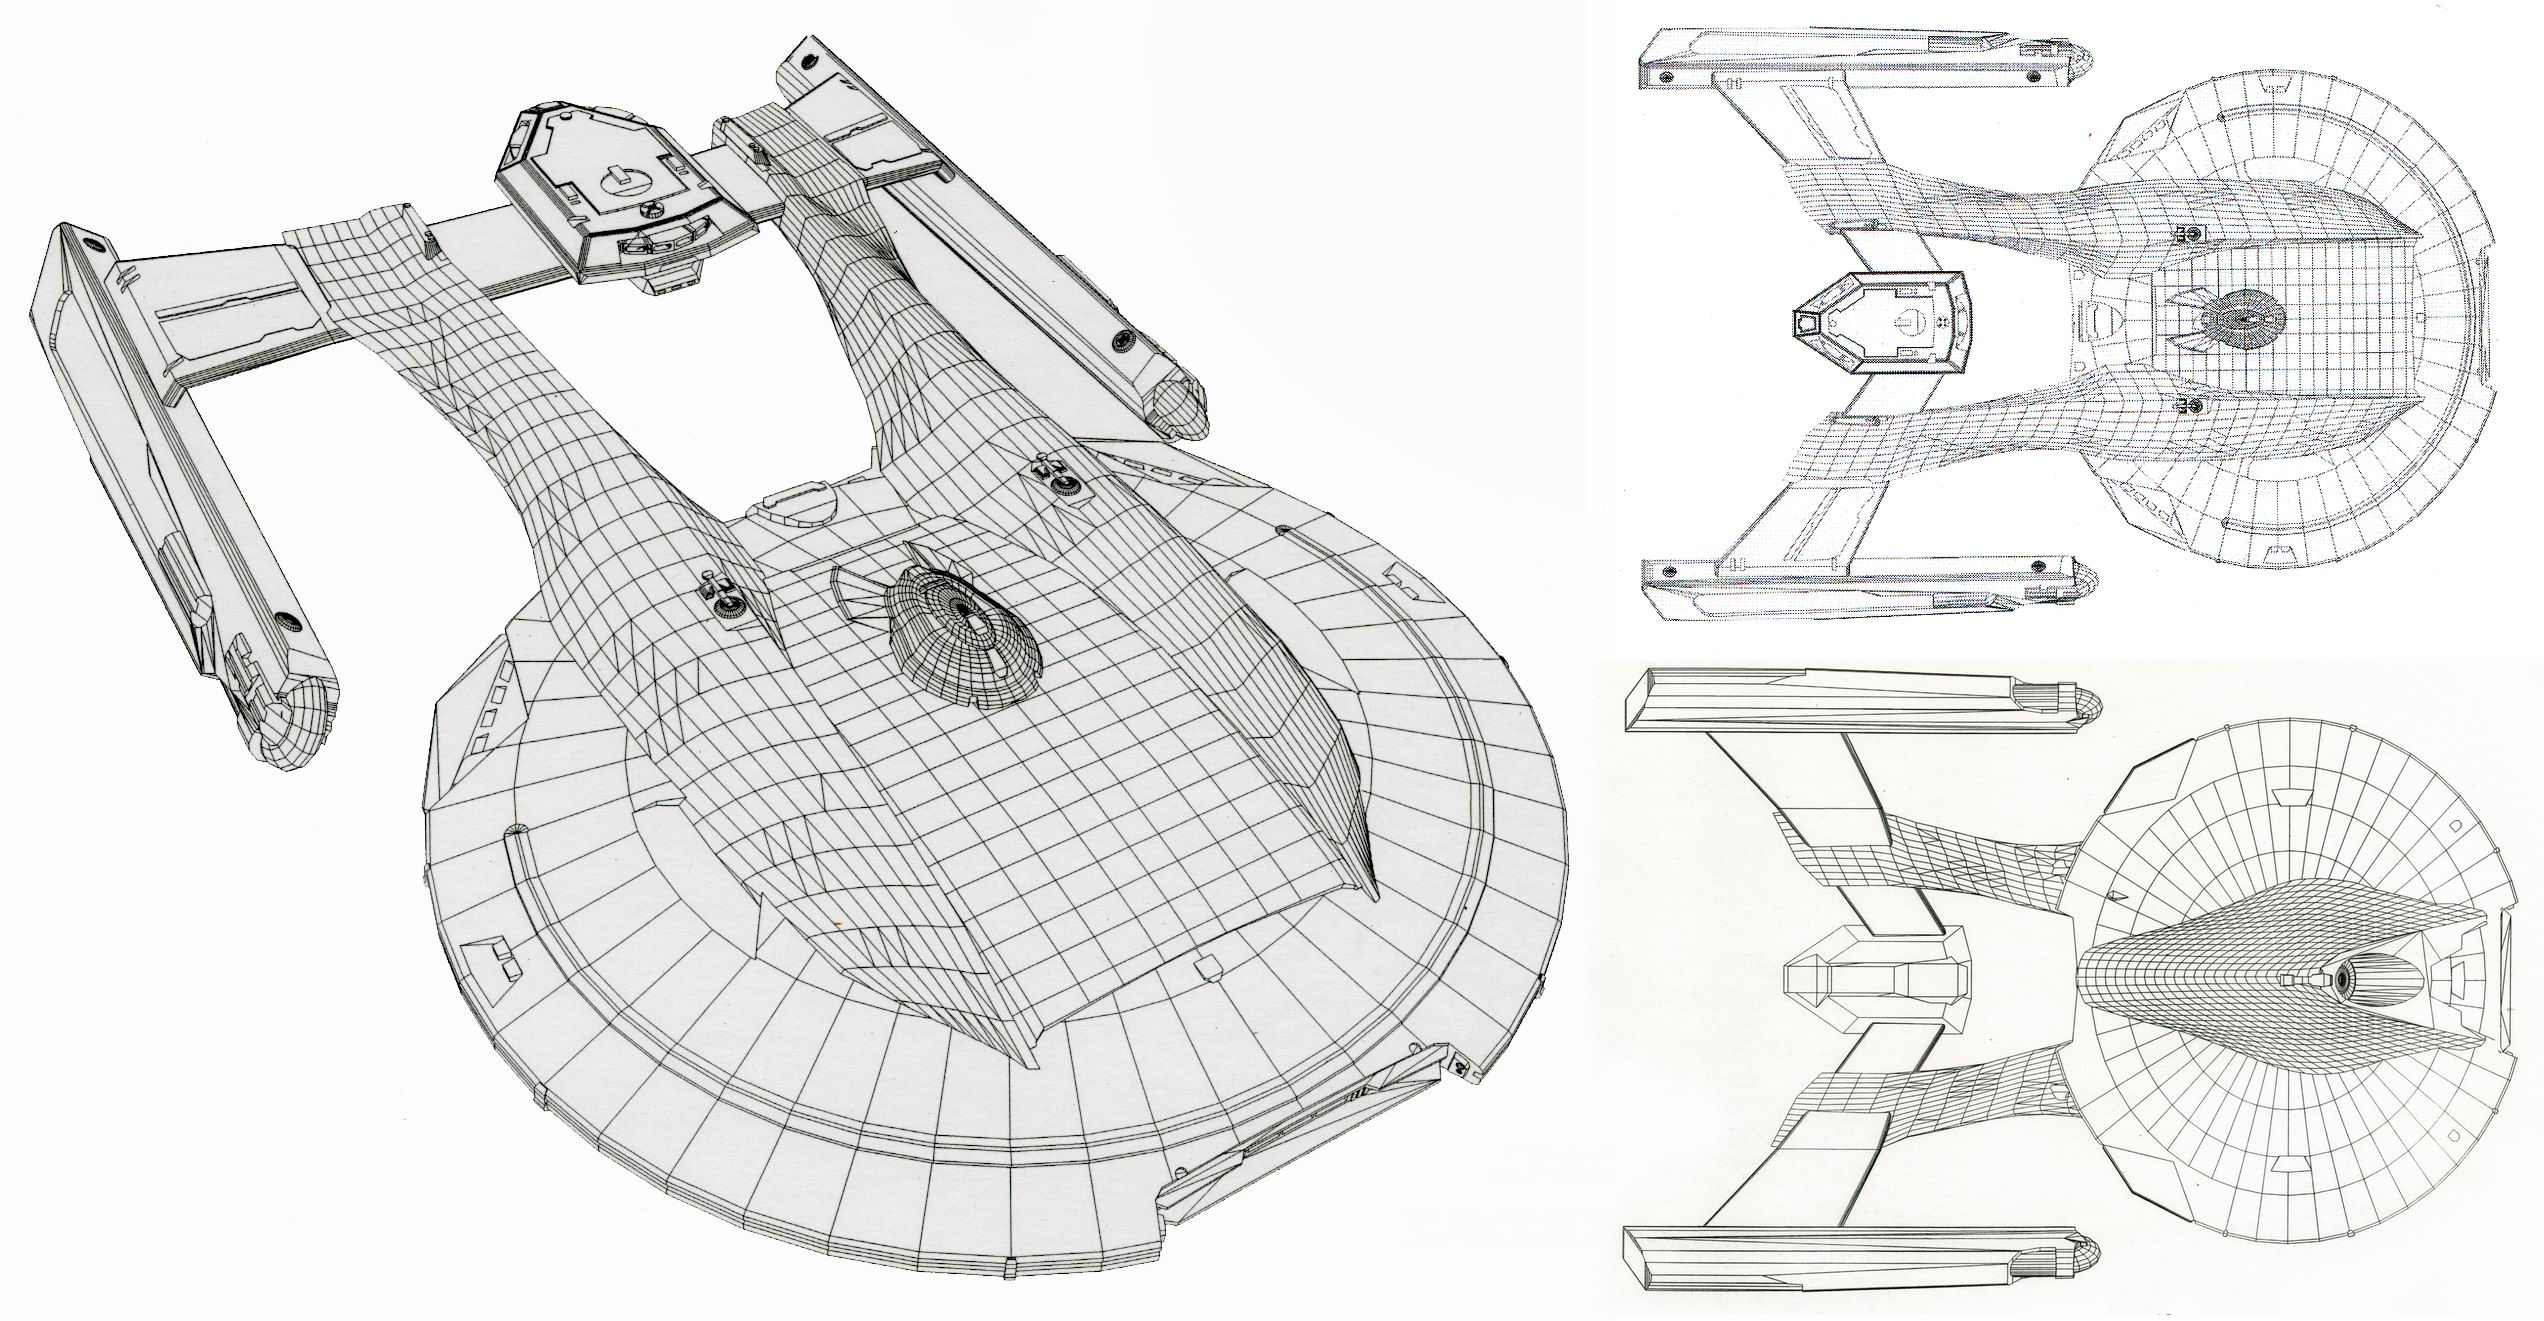

In [2]:
# source http://vignette4.wikia.nocookie.net/memoryalpha/images/8/87/Akira_class_CGI_wireframe_model_by_ILM.jpg/revision/latest?cb=20130221104236&path-prefix=en
display(Image("images/ComputerGraphics/Akira_class_CGI_wireframe_model_by_ILM.jpg", width=750))

Initially, object models may be expressed in terms of smooth functions like polynomials.   

However the first step is to convert those smooth functions into a set of discrete pieces -- coordinates and line segments.   

All subsequent processing is done in terms of the discrete coordinates that approximate the shape of the original model.  

The reason for this conversion is that most transformations needed in graphics are _linear._  

Expressing the scene in terms of coordinates is equivalent to expressing it in terms of vectors, eg, in $\mathbb{R}^3$.   

And linear transformations on vectors are always matrix multiplications, so implementation is simple and uniform.

The resulting representation consists of lists of 3D coordinates called _faces._   Each face is a polygon.

The lines drawn between coordinates are implied by the way that coordinates are grouped into faces. 

__Example.__

Here is a view of a ball-like object.  It is centered at the origin.

The ball is represented in terms of 3D coordinates, but we are only plotting the $x$ and $y$ coordinates here.

Colors correspond to faces.

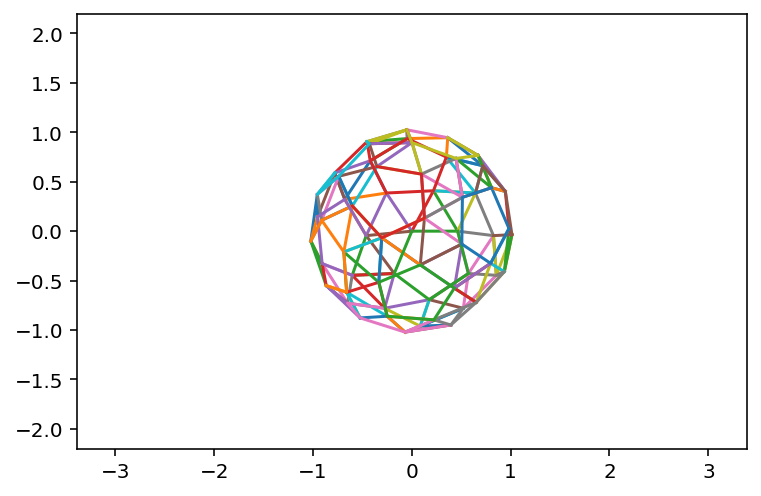

In [21]:
# load ball wireframe
import obj2clist as obj
reload(obj)
fp = open('snub_icosidodecahedron.wrl','r')
ball = obj.wrl2flist(fp)
fp.close()
# set up view
fig = plt.figure()
ax = plt.axes(xlim=(-5,5),ylim=(-5,5))
plt.plot(-2,-2,'')
plt.plot(2,2,'')
plt.axis('equal')
for b in ball:
    ax.plot(b[0],b[1])

Imagine that we want to circle the camera around the ball.   This is equivalent to rotating the ball around the $y$ axis.

This is a linear transformation.  We can implement it by multiplying the coordinates of the ball by a _rotation matrix._   To define the rotation matrix, we need to think about what happens to each of the columns of $I: {\bf e_1, e_2, e_3.}$

To rotate through an angle of $\alpha$ radians around the $y$ axis, the vector ${\bf e_1} = \left[\begin{array}{r}1\\0\\0\end{array}\right]$ goes to $\left[\begin{array}{c}\cos \alpha\\0\\\sin \alpha\end{array}\right].$

Of course, ${\bf e_2}$ is unchanged.

And ${\bf e_3} = \left[\begin{array}{r}0\\0\\1\end{array}\right]$ goes to $\left[\begin{array}{c}-\sin \alpha\\0\\\cos \alpha\end{array}\right].$

So the entire rotation matrix is:

$$\mat{{ccc}\cos \alpha&0&-\sin \alpha\\0&1&0\\\sin \alpha&0&\cos\alpha}.$$

In [22]:
sl.hide_code_in_slideshow()
import base64

# python notebook does not support matplotlib animations
# so these functions create an .mp4 video and then display
# it using inline HTML

# updated to python 3, uses base64 for encoding

# Source: http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/AnimationEmbedding.ipynb
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [23]:
# set up view
import matplotlib.animation as animation
fig = plt.figure()
ax = plt.axes(xlim=(-5,5),ylim=(-5,5))
plt.plot(-2,-2,'')
plt.plot(2,2,'')
plt.axis('equal')
ballLines = []
for b in ball:
    ballLines += ax.plot([],[])
def animate(i):
    angle = 2.0 * np.pi * (i/100.0)
    rotationMatrix = np.array([[np.cos(angle),0,-np.sin(angle)],
                               [0,1,0],[np.sin(angle),0,np.cos(angle)]])
    for b,l in zip(ball,ballLines):
        rb = rotationMatrix.dot(b)
        l.set_data(rb[0],rb[1])
    fig.canvas.draw()
anim = animation.FuncAnimation(fig,animate,frames=100,interval=100,repeat=False,blit=False)
# this function requires ffmpeg to be installed on your system
display_animation(anim)

## Translation

Manipulating graphics objects using matrix multiplication is very convenient.

However, there is a common operation that is __not__ a linear transformation: _translation_, aka motion.

The standard way to avoid this difficulty is to use what are called __homogeneous coordinates.__

We identify each point $\left[\begin{array}{r}x\\y\\z\end{array}\right] \in \mathbb{R}^3$ with a corresponding point $\left[\begin{array}{r}x\\y\\z\\1\end{array}\right] \in \mathbb{R}^4.$  

The coordinates of the point in $\mathbb{R}^4$ are the homogeneous coordinates for the point in $\mathbb{R}^3.$

The extra component gives us a constant that we can scale and add to the other coordinates, as needed, via matrix multiplication.

This means for 3D graphics, all transformation matrices are $4\times 4.$

__Example.__

Let's say we want to move a point $(x, y, z)$ to location $(x+h, y+k, z+m).$

We represent the point in homogeneous coordinates as $\left[\begin{array}{r}x\\y\\z\\1\end{array}\right].$

The transformation corresponding to this 'translation' is:

$$\left[\begin{array}{cccc}1&0&0&h\\0&1&0&k\\0&0&1&m\\0&0&0&1\end{array}\right]\left[\begin{array}{r}x\\y\\z\\1\end{array}\right] = \left[\begin{array}{c}x+h\\y+k\\z+m\\1\end{array}\right].$$

If we only consider $x, y,$ and $z$ this is not a linear transformation.   But of course, in $\mathbb{R}^4$ this most definitely __is__ a linear transformation.   

We have 'sheared' the fourth dimension, which affects the other three. A very useful trick!

__Constructing Matrices for Homogeneous Coordinates__

For any transformation $A$ that is linear in $\mathbb{R}^3$ (such as scaling, rotation, reflection, shearing, etc.), we can construct the corresponding matrix for homogeneous coordinates quite simply:

If $$ A = \mat{{rrr}\blacksquare&\blacksquare&\blacksquare\\\blacksquare&\blacksquare&\blacksquare\\\blacksquare&\blacksquare&\blacksquare}$$

Then the corresponding transformation for homogeneous coordinates is:

$$\mat{{rrrr}\blacksquare&\blacksquare&\blacksquare&0\\\blacksquare&\blacksquare&\blacksquare&0\\\blacksquare&\blacksquare&\blacksquare&0\\0&0&0&1}$$

In other words, when performing a linear transformation on $x, y$, and $z$, one simply 'carries along' the extra coordinate without modifying it.

## Perspective Projections

There is another nonlinear transformation that is important in computer graphics: perspective.

Happily, we will see that homogeneous coordinates allow us to capture this too as a linear transformation in $\mathbb{R}^4$.

The eye, or a camera, captures light (essentially) in a single location, and hence gathers light rays that are converging. 

So, to portray a scene with realistic appearance, it is necessary to reproduce this effect.   

The effect can be thought of as "nearer objects are larger than further objects."

This was (re)discovered by Renaissance artists (supposedly first by Filippo Brunelleschi, around 1405).

Here is a famous example: Raphael's _School of Athens_ (1510).

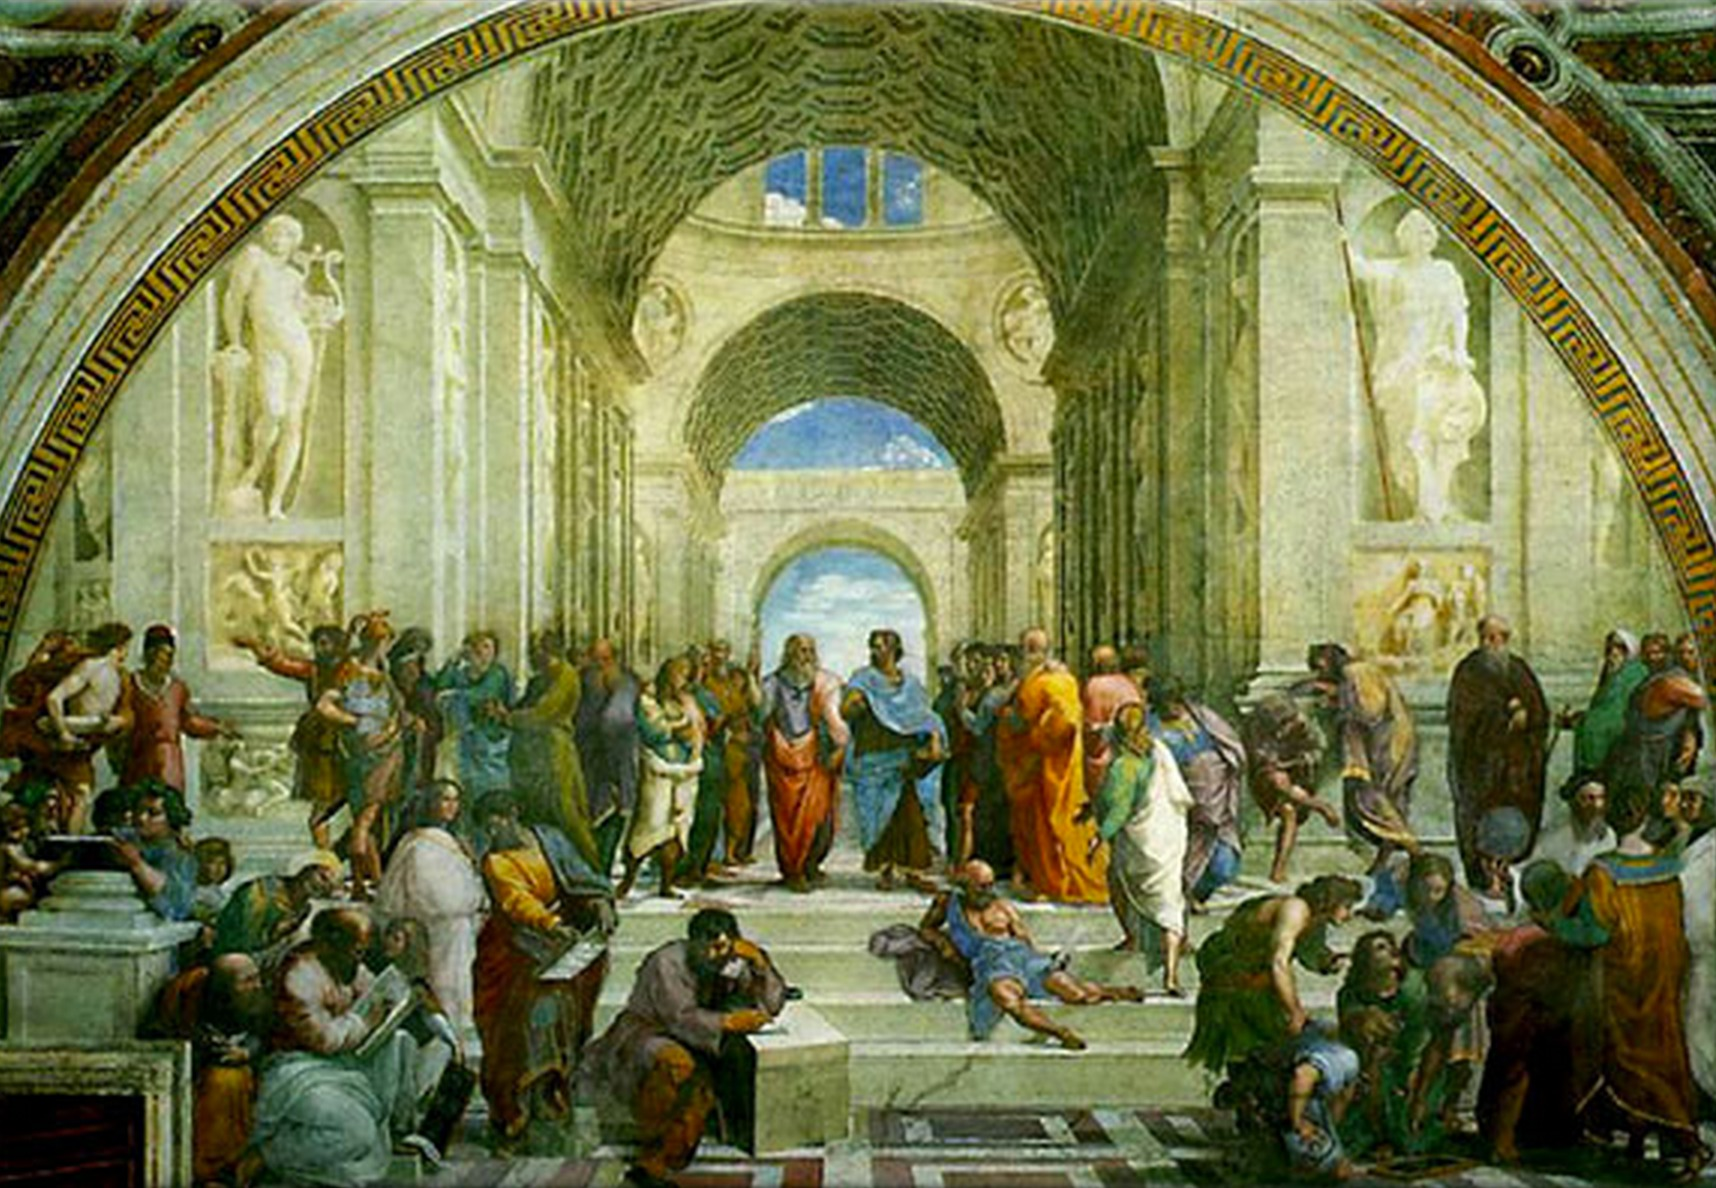

In [6]:
sl.hide_code_in_slideshow()
#source: http://www.webexhibits.org/sciartperspective/tylerperspective.html
display(Image("images/Raphael-SchoolofAthens.jpg", width=750))

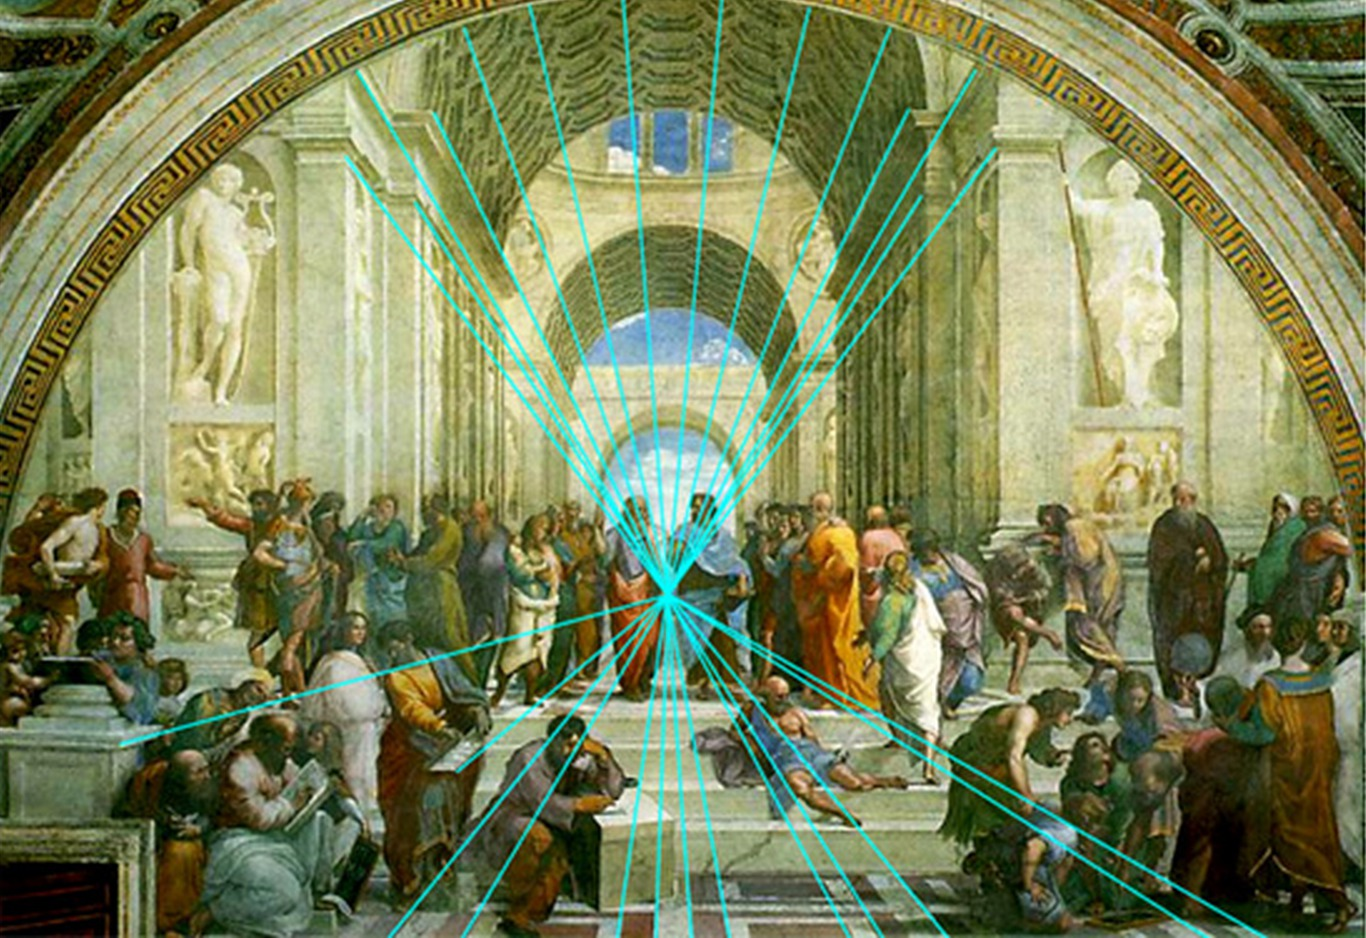

In [7]:
sl.hide_code_in_slideshow()
display(Image("images/Raphael-SchoolofAthens-Perspective.jpg", width=750))

We now understand that this effect interacts in a powerful way with neural circuitry in our brains.  

The mind reconstructs a sense of three dimensions from the two dimensional information presented to it by the retina.  

This is done by sophisticated processing in the visual cortex, which is a fairly large portion of the brain.

In [8]:
sl.hide_code_in_slideshow()
fig = plt.figure()
ax = plt.axes(xlim=(-5,5),ylim=(-5,5))
plt.plot(-2,-2,'')
plt.plot(2,2,'')
plt.axis('equal')
fp = open('cube.obj','r')
cube = obj.obj2flist(fp)
fp.close()
cube = obj.homogenize(cube)
cubeLines = []
for c in cube:
    cubeLines += ax.plot([],[])
def animate(i):
    angle = 2.0 * np.pi * (i/100.0)
    P = np.array([[1.,0,0,0],[0,1.,0,0],[0,0,0,0],[0,0,-1./8,1]]).dot(np.array([[np.cos(angle),0,-np.sin(angle),0],[0,1,0,0],[np.sin(angle),0,np.cos(angle),0],[0,0,0,1]]))
    for b,l in zip(cube,cubeLines):
        rb = P.dot(b)
        l.set_data(rb[0]/rb[3],rb[1]/rb[3])
    fig.canvas.draw()
anim = animation.FuncAnimation(fig,animate,frames=101,interval=100,repeat=False,blit=False)
# this function requires ffmpeg to be installed on your system
display_animation(anim)

Notice that when the image is stationary, it appears flat (like a picture frame).  As soon as it starts to move, it springs into 3D in perception.

__Computing Perspective.__

A standard setup for computing a perspective transformation is as shown in this figure:

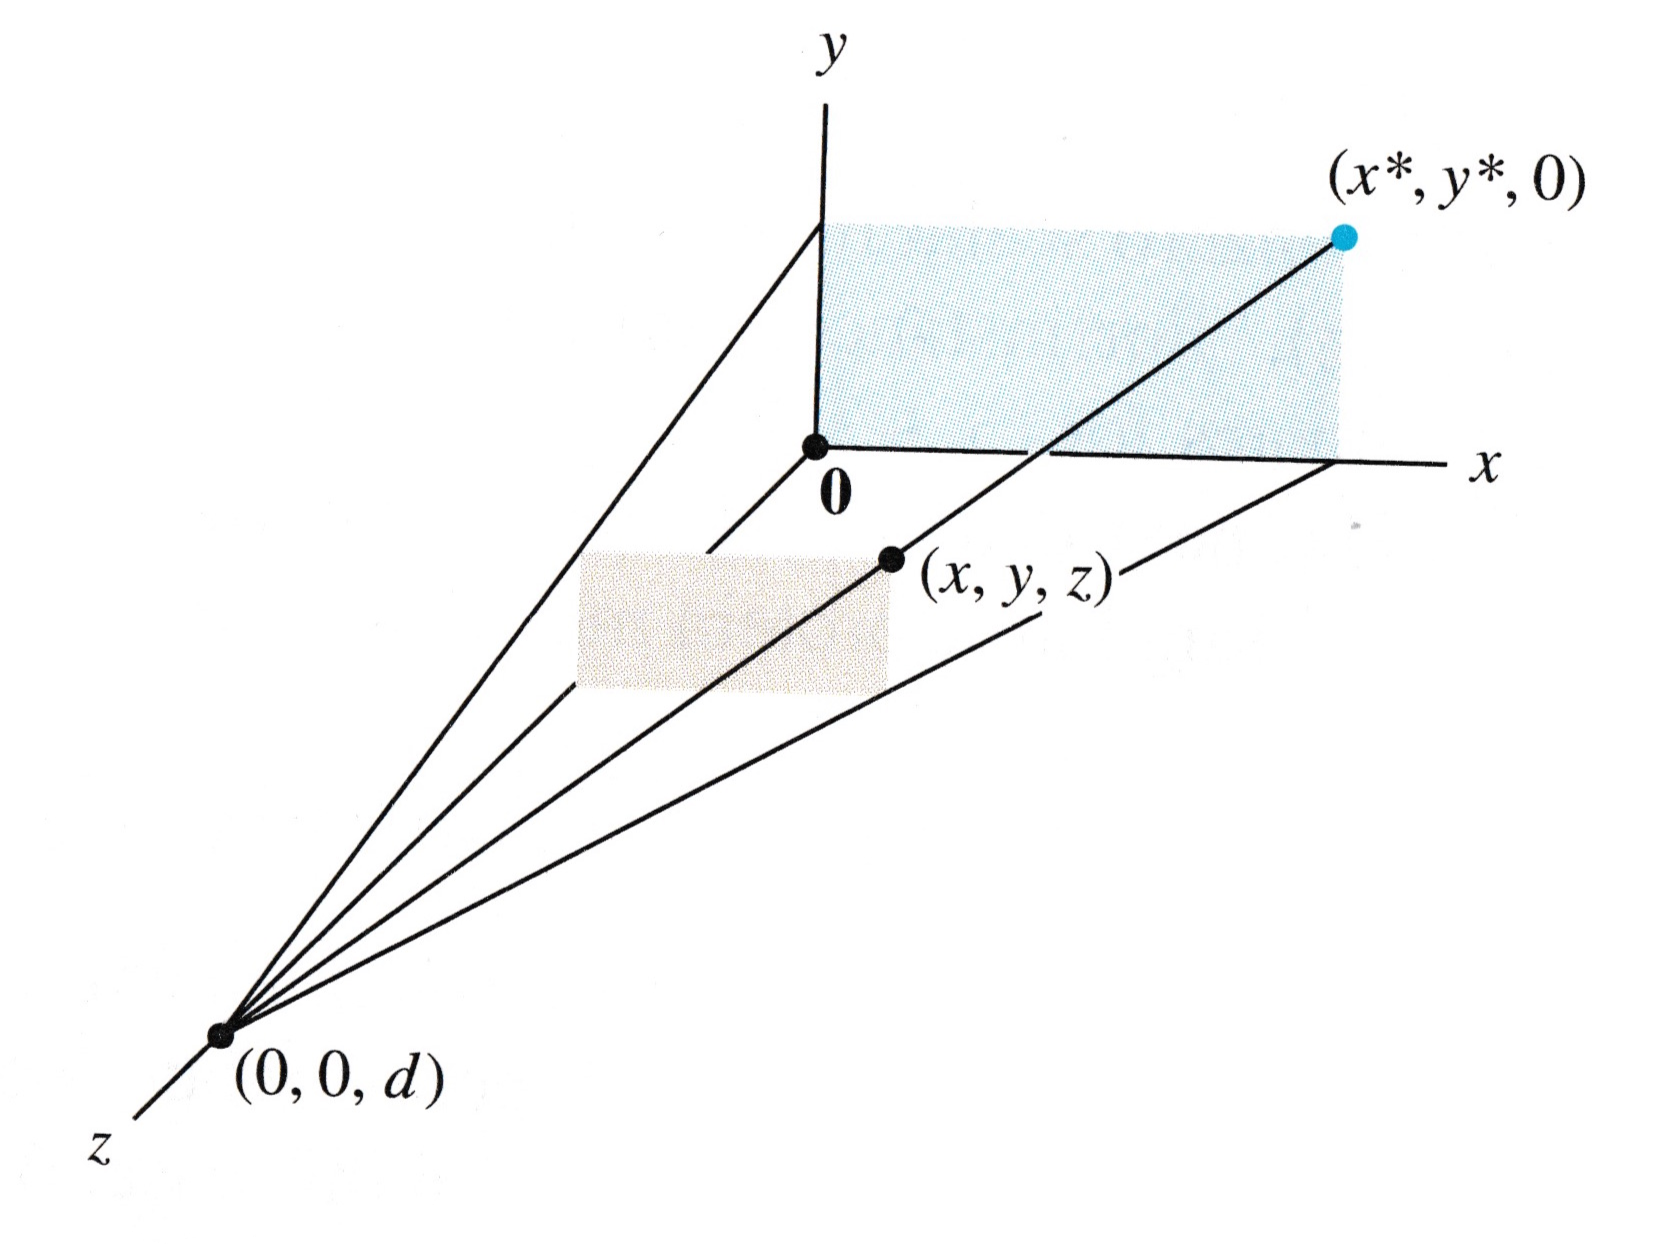

In [9]:
# source: Lay, 4th edition
display(Image("images/Lay-fig-2-7-1.png", width=550))

For simplicity, we will let the $xy$-plane represent the screen.  This is called the _viewing plane._  

The eye/camera is located on the $z$ axis, at the point $(0,0,d)$.  This is call the _center of projection._

A _perspective projection_ maps each point $(x,y,z)$ onto an image point $(x^*,y^*,0)$ so that the center of projection and the two points are all on the same line.

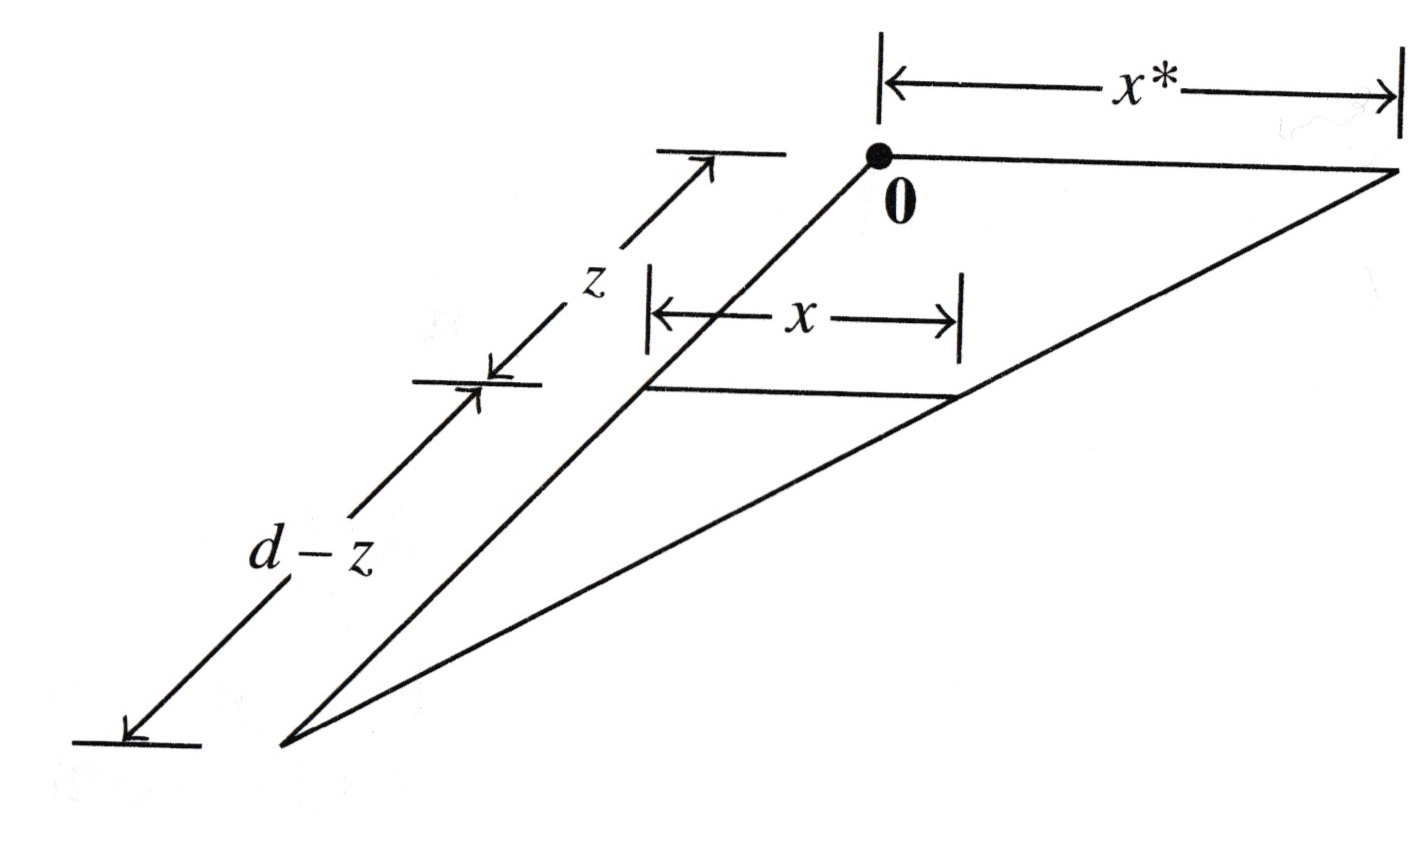

In [10]:
# source: Lay, 4th edition
display(Image("images/Lay-fig-2-7-2.png", width=550))

The way to compute the projection is using similar triangles.

The triangle in the $xz$-plane shows the lengths of corresponding line segments.

Similar triangles show that

$$\frac{x^*}{d} = \frac{x}{d-z}$$

and so

$$x^*=\frac{dx}{d-z}\;=\;\frac{x}{1-z/d}.$$

Notice that the function $T: (x,z)\mapsto\frac{x}{1-z/d}$ is __not__ linear.

Using homogeneous coordinates, we can construct a linear version of $T$ in $\mathbb{R}^4.$

To do so, we establish the following convention: we will allow the fourth coordinate to vary away from 1.

However, when we plot, for a point $\mat{{r}x\\y\\z\\h}$ we will plot the point $\mat{{r}\frac{x}{h}\\\frac{y}{h}\\\frac{z}{h}}.$   

In this way, by dividing the $x,y,z$ coordinates by the $h$ coordinate, we can implement a __nonlinear__ transform in $\mathbb{R}^3.$

So, to implement the perspective transform, we want $\mat{{r}x\\y\\z\\1}$ to map to $\mat{{c}\frac{x}{1-z/d}\\\frac{y}{1-z/d}\\0\\1}.$   

The way we will implement this is to actually cause it to map to  $\mat{{c}x\\y\\0\\1-z/d}.$

Then, when we plot (dividing $x$ and $y$ by the $h$ value) we will get the proper transform.

The matrix that implements this transformation is quite simple:

$$\mat{{cccc}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&-1/d&1}.$$

So:

$$\mat{{cccc}1&0&0&0\\0&1&0&0\\0&0&0&0\\0&0&-1/d&1}\mat{{r}x\\y\\z\\1} = \mat{{c}x\\y\\0\\1-z/d}.$$

## Composing Transformations

One big payoff for casting all graphics operations as linear transformations comes in the __composition__ of transformations.

Consider two linear transformations $T$ and $S$.   For example, $T$ could be a scaling and $S$ could be a rotation.  Assume $S$ is implemented by a matrix $A$ and $T$ is implemented by a matrix $B$. 

To first scale and then rotate a vector $\vx$ we would compute $S(T(\vx))$.

Of course this is implemented as $A(B\vx).$

But note that this is the same as $(AB)\vx.$   In other words, $AB$ is a _single matrix that both scales and rotates_ $\vx$.  

By extension, we can combine any arbitrary sequence of linear transformations into a single matrix.   This greatly simplifies high-speed graphics.  

Note though that if $C = AB$, then $C$ is the transformation that _first_ applies $B$, _then_ applies $A$.

__Example.__   Let's work in homogenous coordinates for points in $\R^2$.    Find the $3\times 3$ matrix that corresponds to the composite transformation of first scaling by 0.3, then rotation of 90$^\circ$ about the origin, and finally a translation of $\mat{{c}-0.5\\2}$ to each point of a figure.

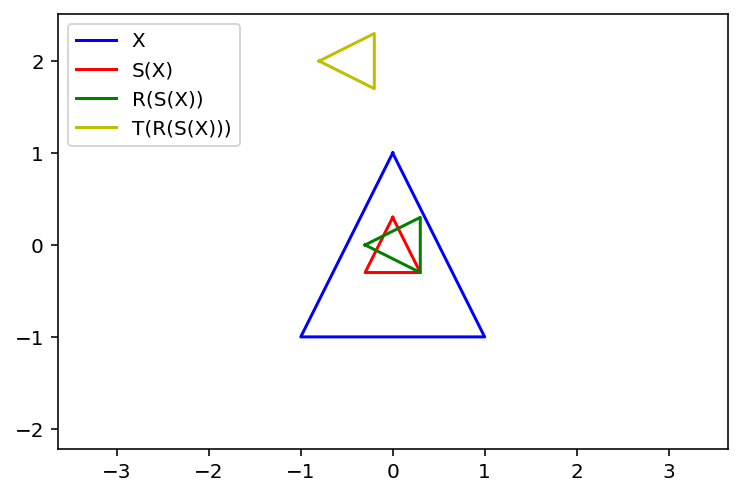

In [11]:
# set up view
fig = plt.figure()
ax = plt.axes(xlim=(-5,5),ylim=(-5,5))
plt.plot(-2,-2,'')
plt.plot(2,2,'')
plt.axis('equal')
tri = np.array([[0.,1,-1,0],[1,-1,-1,1],[1,1,1,1]])
plt.plot(tri[0]/tri[2],tri[1]/tri[2],'b',label='X')
scale = np.array([[.3,0,0],[0,.3,0],[0,0,1]])
rotate = np.array([[0,-1.,0],[1,0,0],[0,0,1]])
translate = np.array([[1,0,-0.5],[0,1,2],[0,0,1]])
newtri = scale.dot(tri)
plt.plot(newtri[0]/newtri[2],newtri[1]/newtri[2],'r',label='S(X)')
newtri = rotate.dot(scale).dot(tri)
plt.plot(newtri[0]/newtri[2],newtri[1]/newtri[2],'g',label='R(S(X))')
newtri = translate.dot(rotate).dot(scale).dot(tri)
plt.plot(newtri[0]/newtri[2],newtri[1]/newtri[2],'y',label='T(R(S(X)))')
plt.legend();

The scaling matrix is:

$$S = \begin{bmatrix}0.3&0&0\\0&0.3&0\\0&0&1\end{bmatrix}$$

The rotation matrix is:

$$R = \begin{bmatrix}0&-1&0\\1&0&0\\0&0&1\end{bmatrix}$$

(Note that $\sin 90^\circ = 1$ and $\cos 90^\circ = 0.$)

The translation matrix is:

$$T = \begin{bmatrix}1&0&-0.5\\0&1&2\\0&0&1\end{bmatrix}$$

So the matrix for the composite transformation is:

$$TRS = \begin{bmatrix}1&0&-0.5\\0&1&2\\0&0&1\end{bmatrix}\begin{bmatrix}0&-1&0\\1&0&0\\0&0&1\end{bmatrix}\begin{bmatrix}0.3&0.3&0\\0&0.3&0\\0&0&1\end{bmatrix} = \begin{bmatrix}0&-0.3&-0.5\\0.3&0&2\\0&0&1\end{bmatrix}.$$

## Homework 7

Homework 7 will allow you to explore these ideas by computing various transformation matrices.   I will give you some 3D wireframe objects and you will compute the necessary matrices to create a simple animation.

Here is what your finished product will look like:

In [12]:
def display_saved_anim(fname):
    with open(fname,'rb') as f:
        video = f.read()
    return HTML(VIDEO_TAG.format(base64.b64encode(video).decode('utf-8')))
display_saved_anim('images/hwk7Solution.mp4')

## Fast Computation of Linear Systems using Graphics Processing Units (GPUs)

In [13]:
# Note: Another good source is http://pixeljetstream.blogspot.de/2015/02/life-of-triangle-nvidias-logical.html

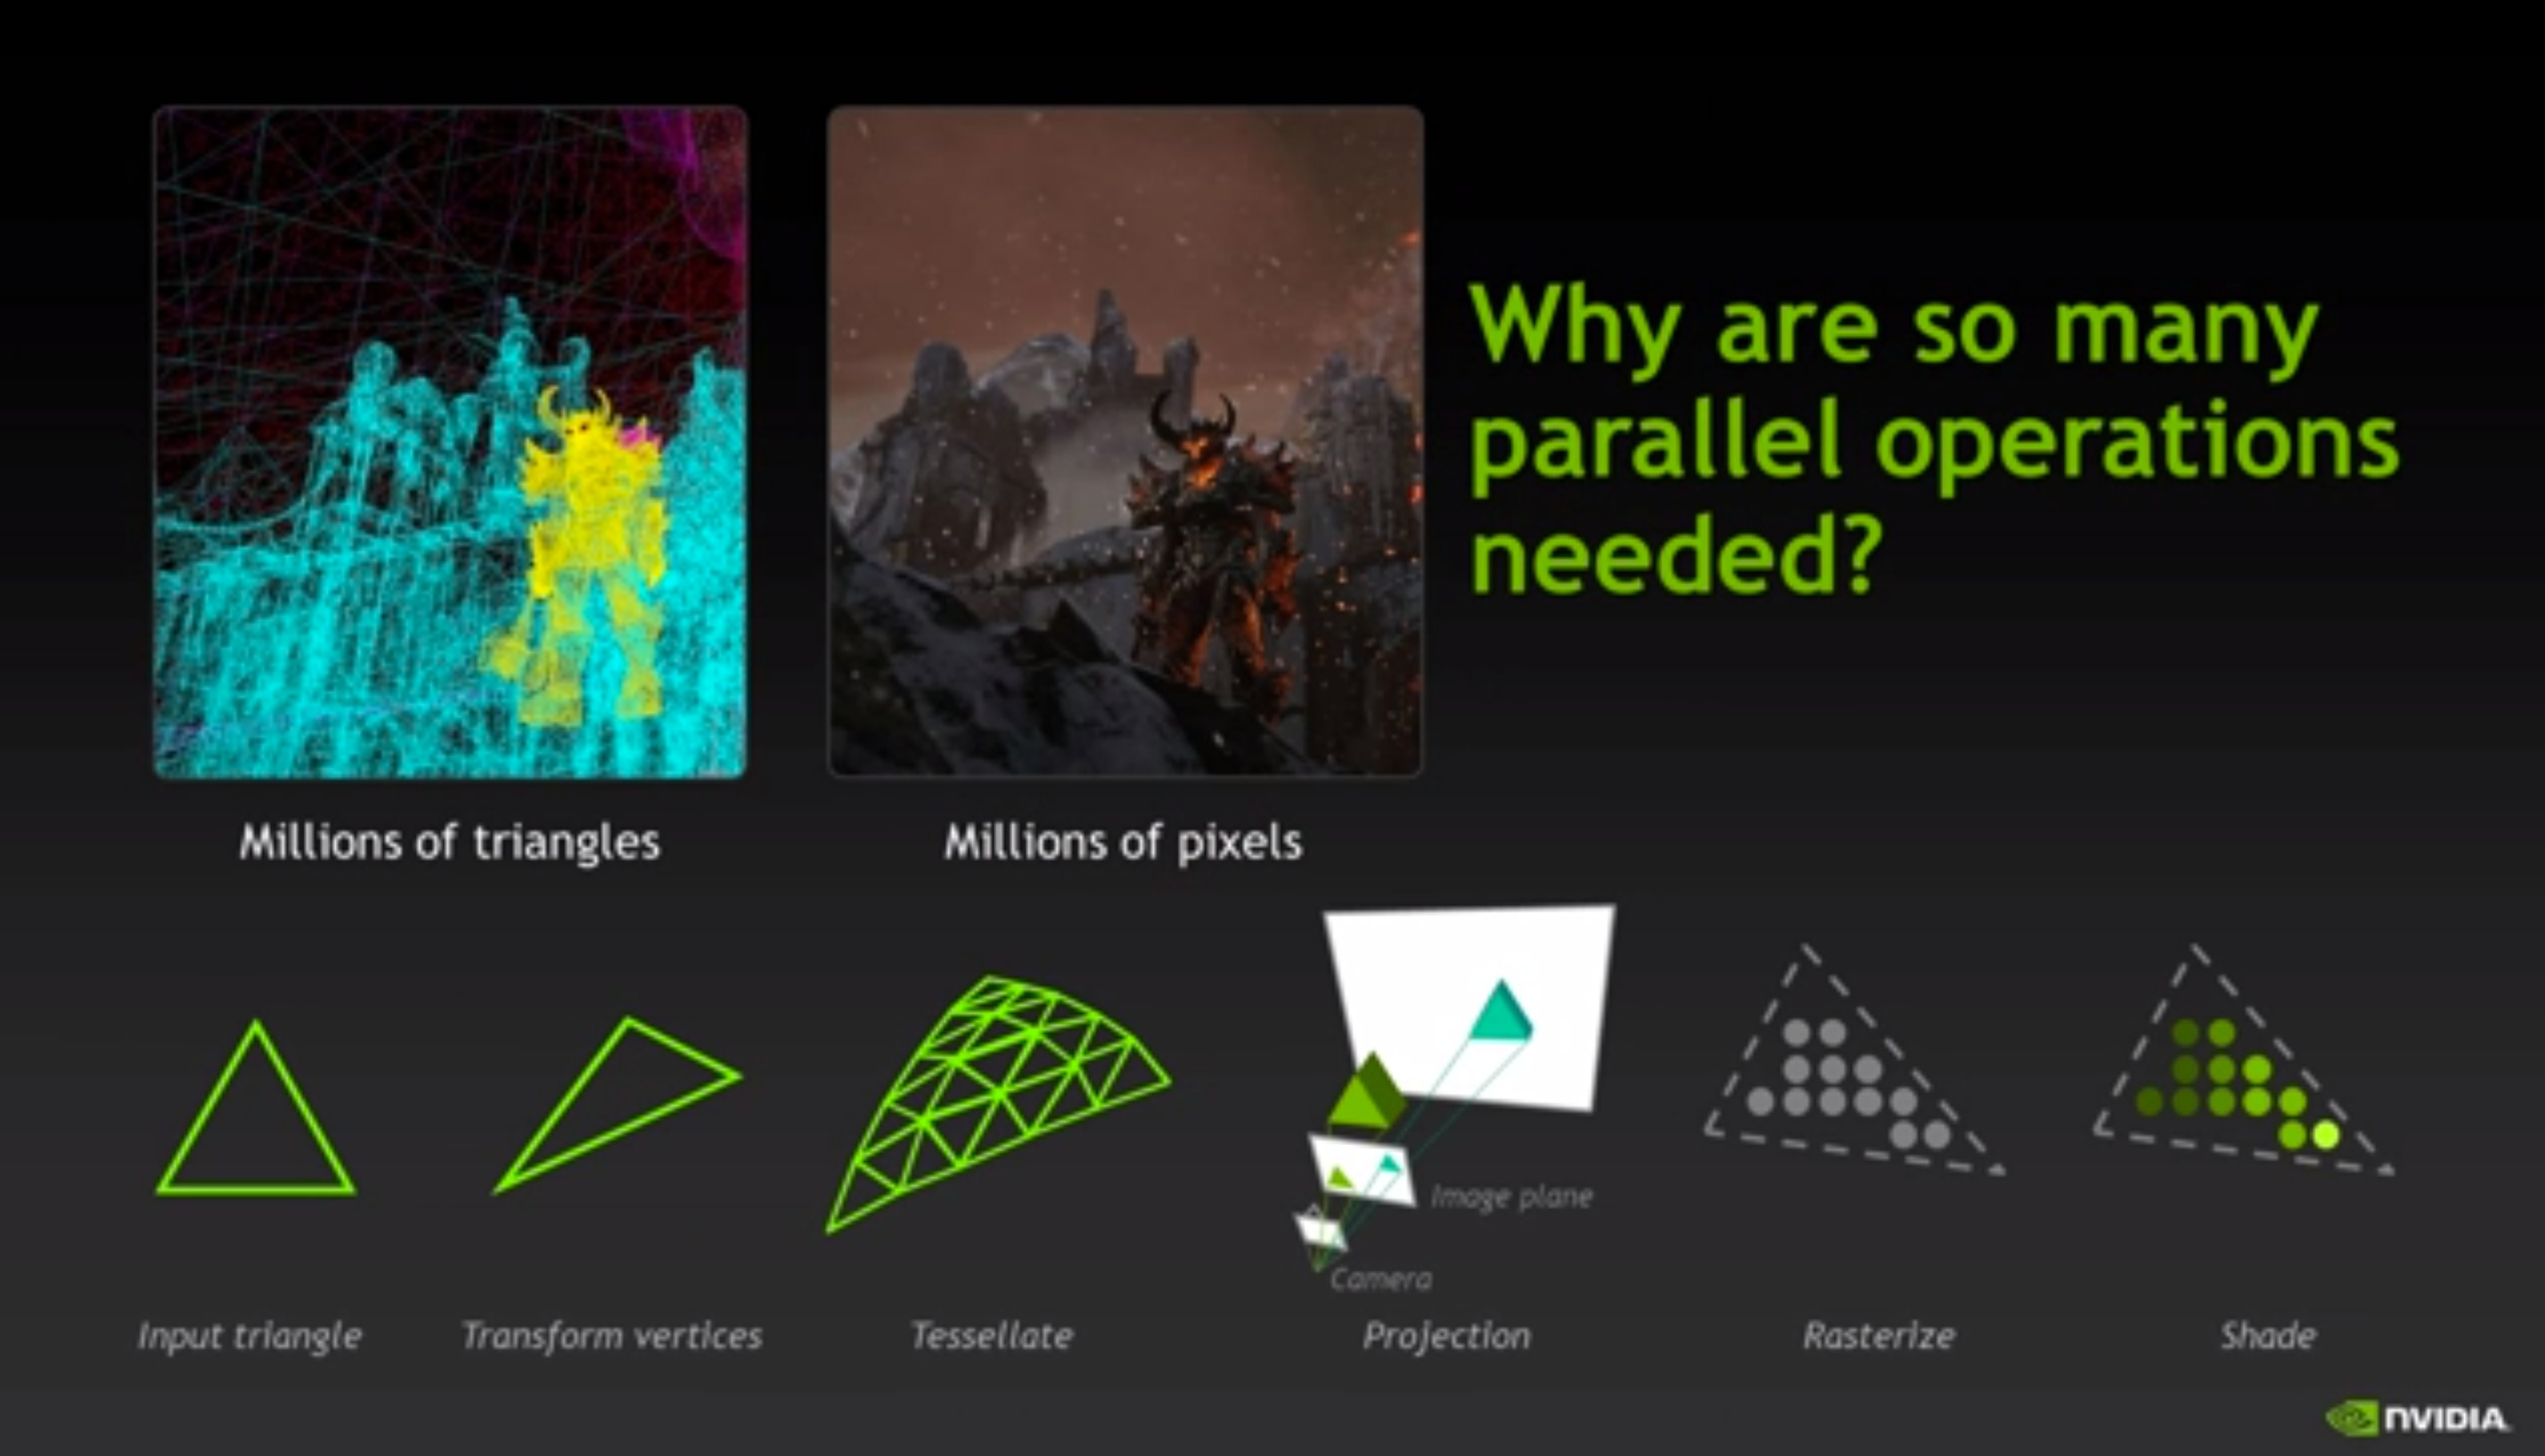

In [14]:
# source http://on-demand.gputechconf.com/gtc/2013/video/S3424-Unlikely-Symbiosis-HPC-And-Gaming.mp4
display(Image("images/ComputerGraphics/Triangle-Processing.jpg", width=550))

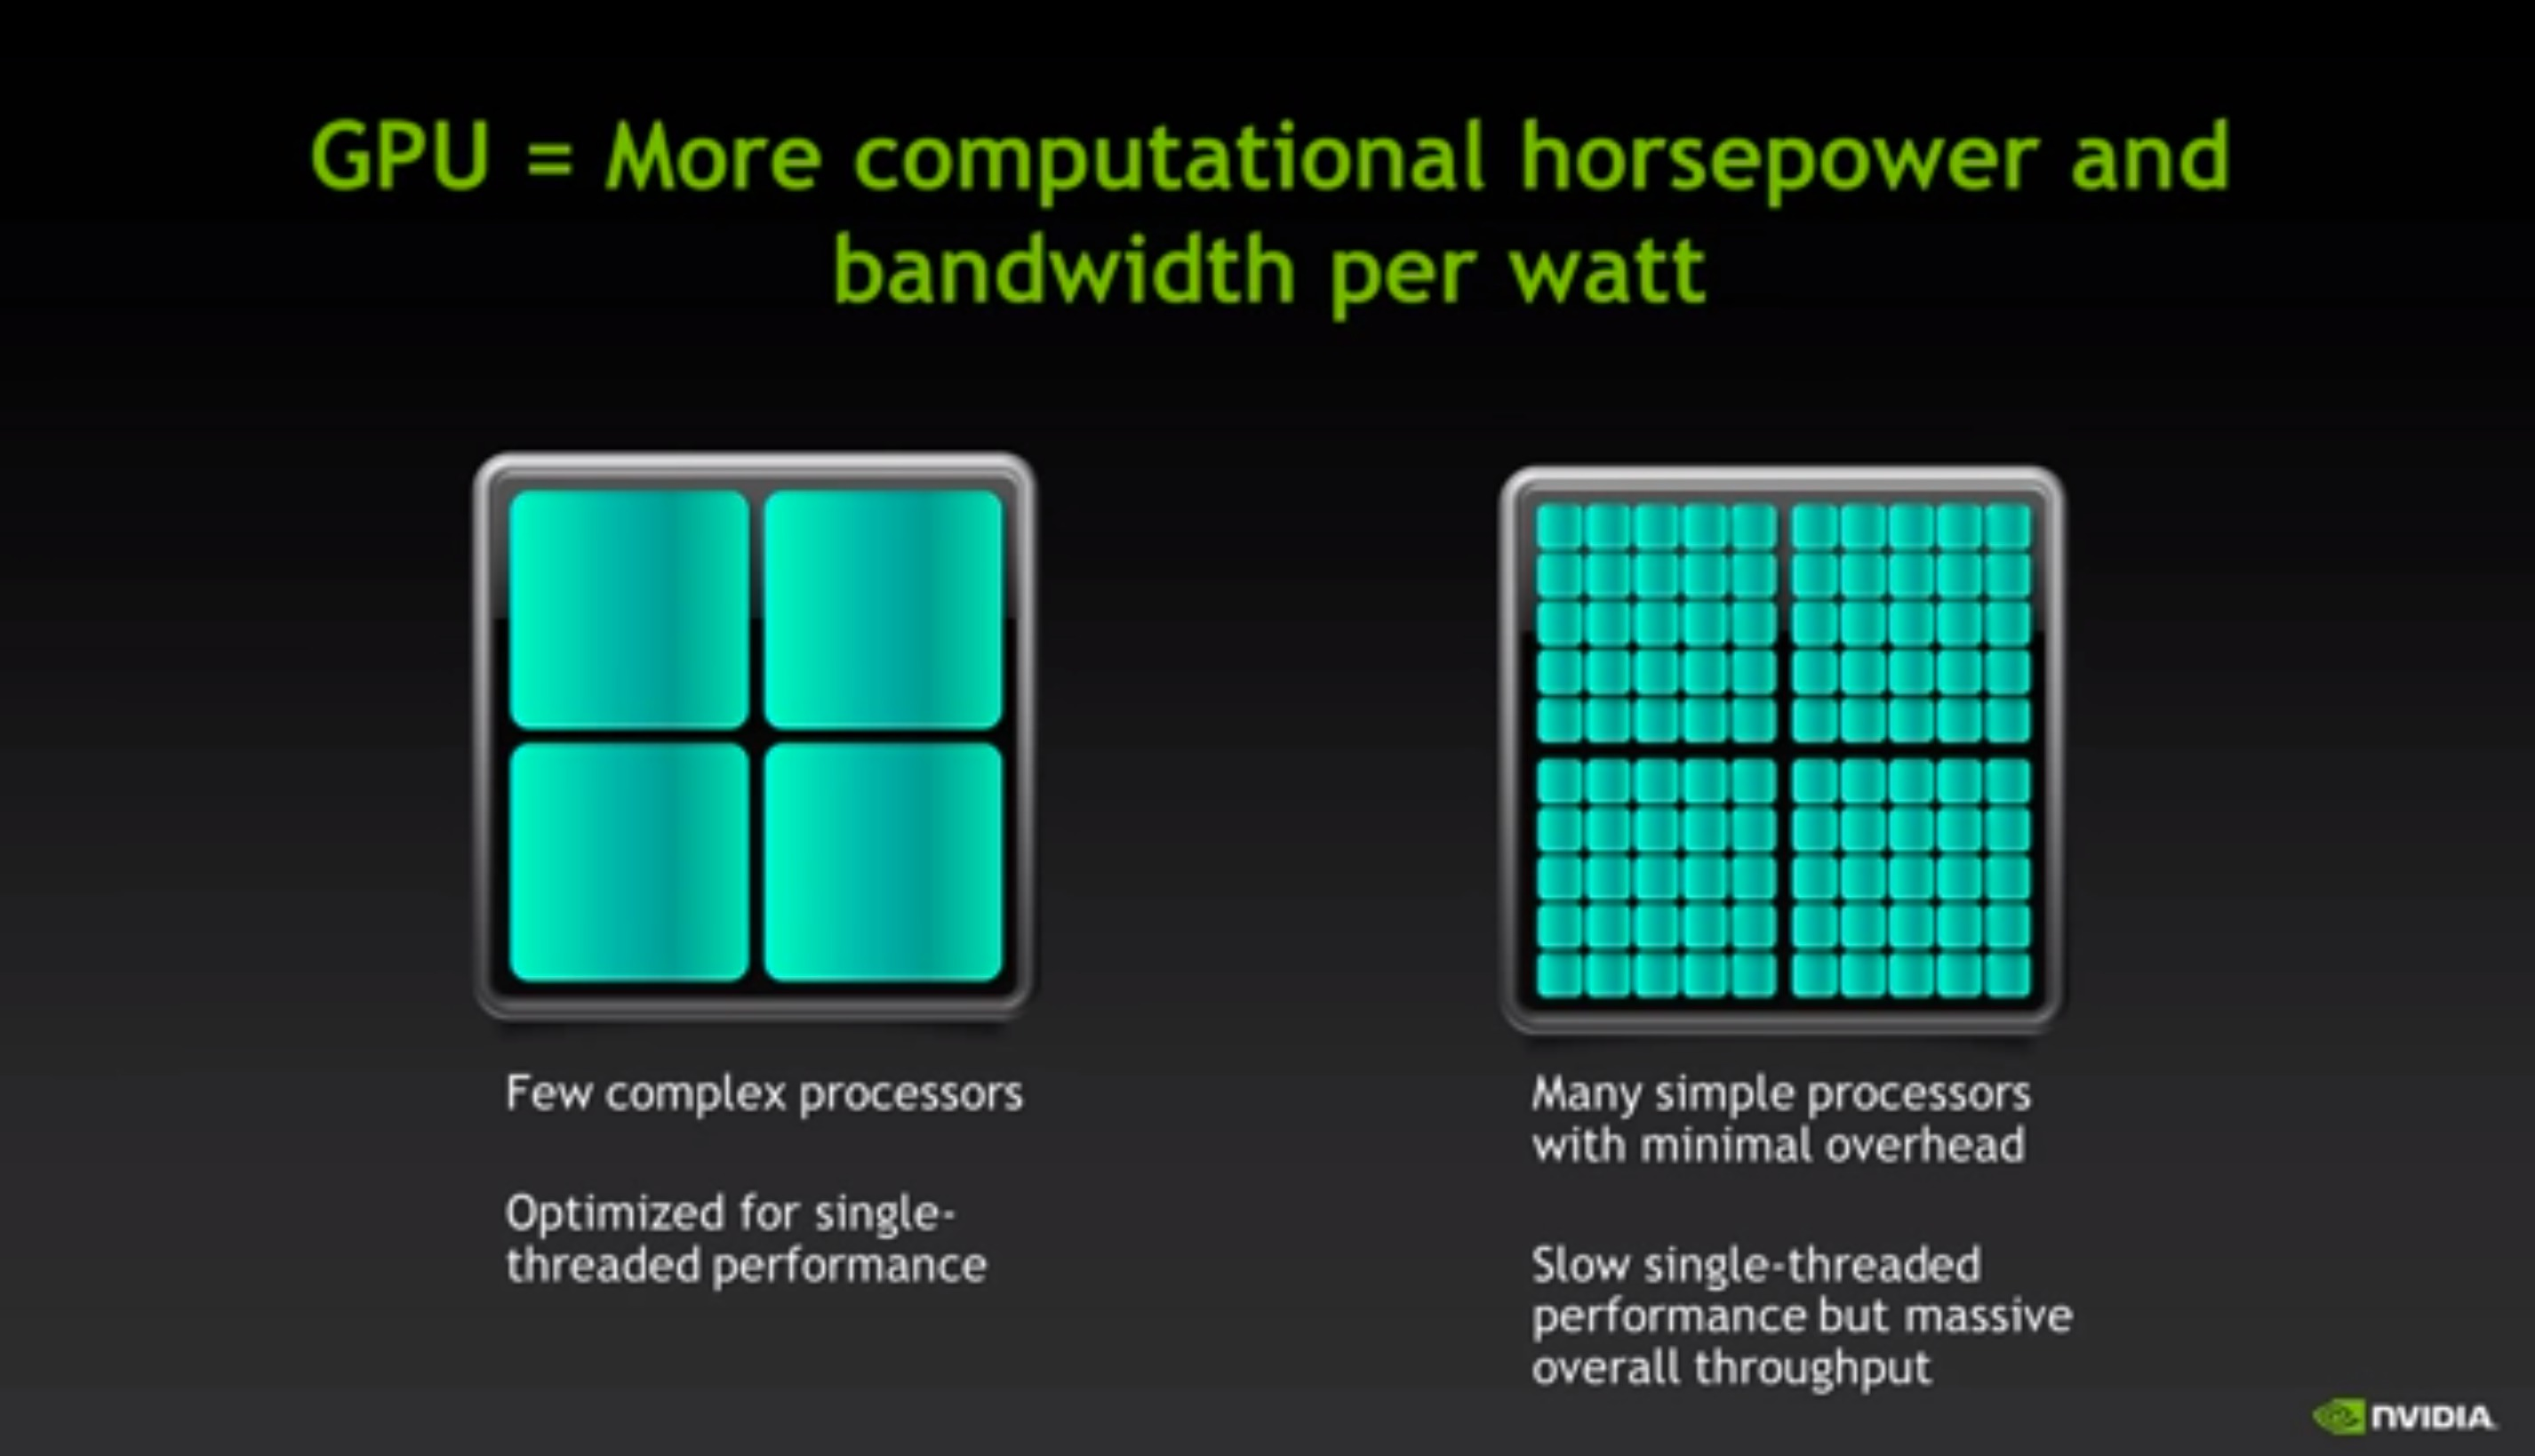

In [15]:
# source http://on-demand.gputechconf.com/gtc/2013/video/S3424-Unlikely-Symbiosis-HPC-And-Gaming.mp4
display(Image("images/ComputerGraphics/CPU-GPU-Comparison.jpg", width=550))

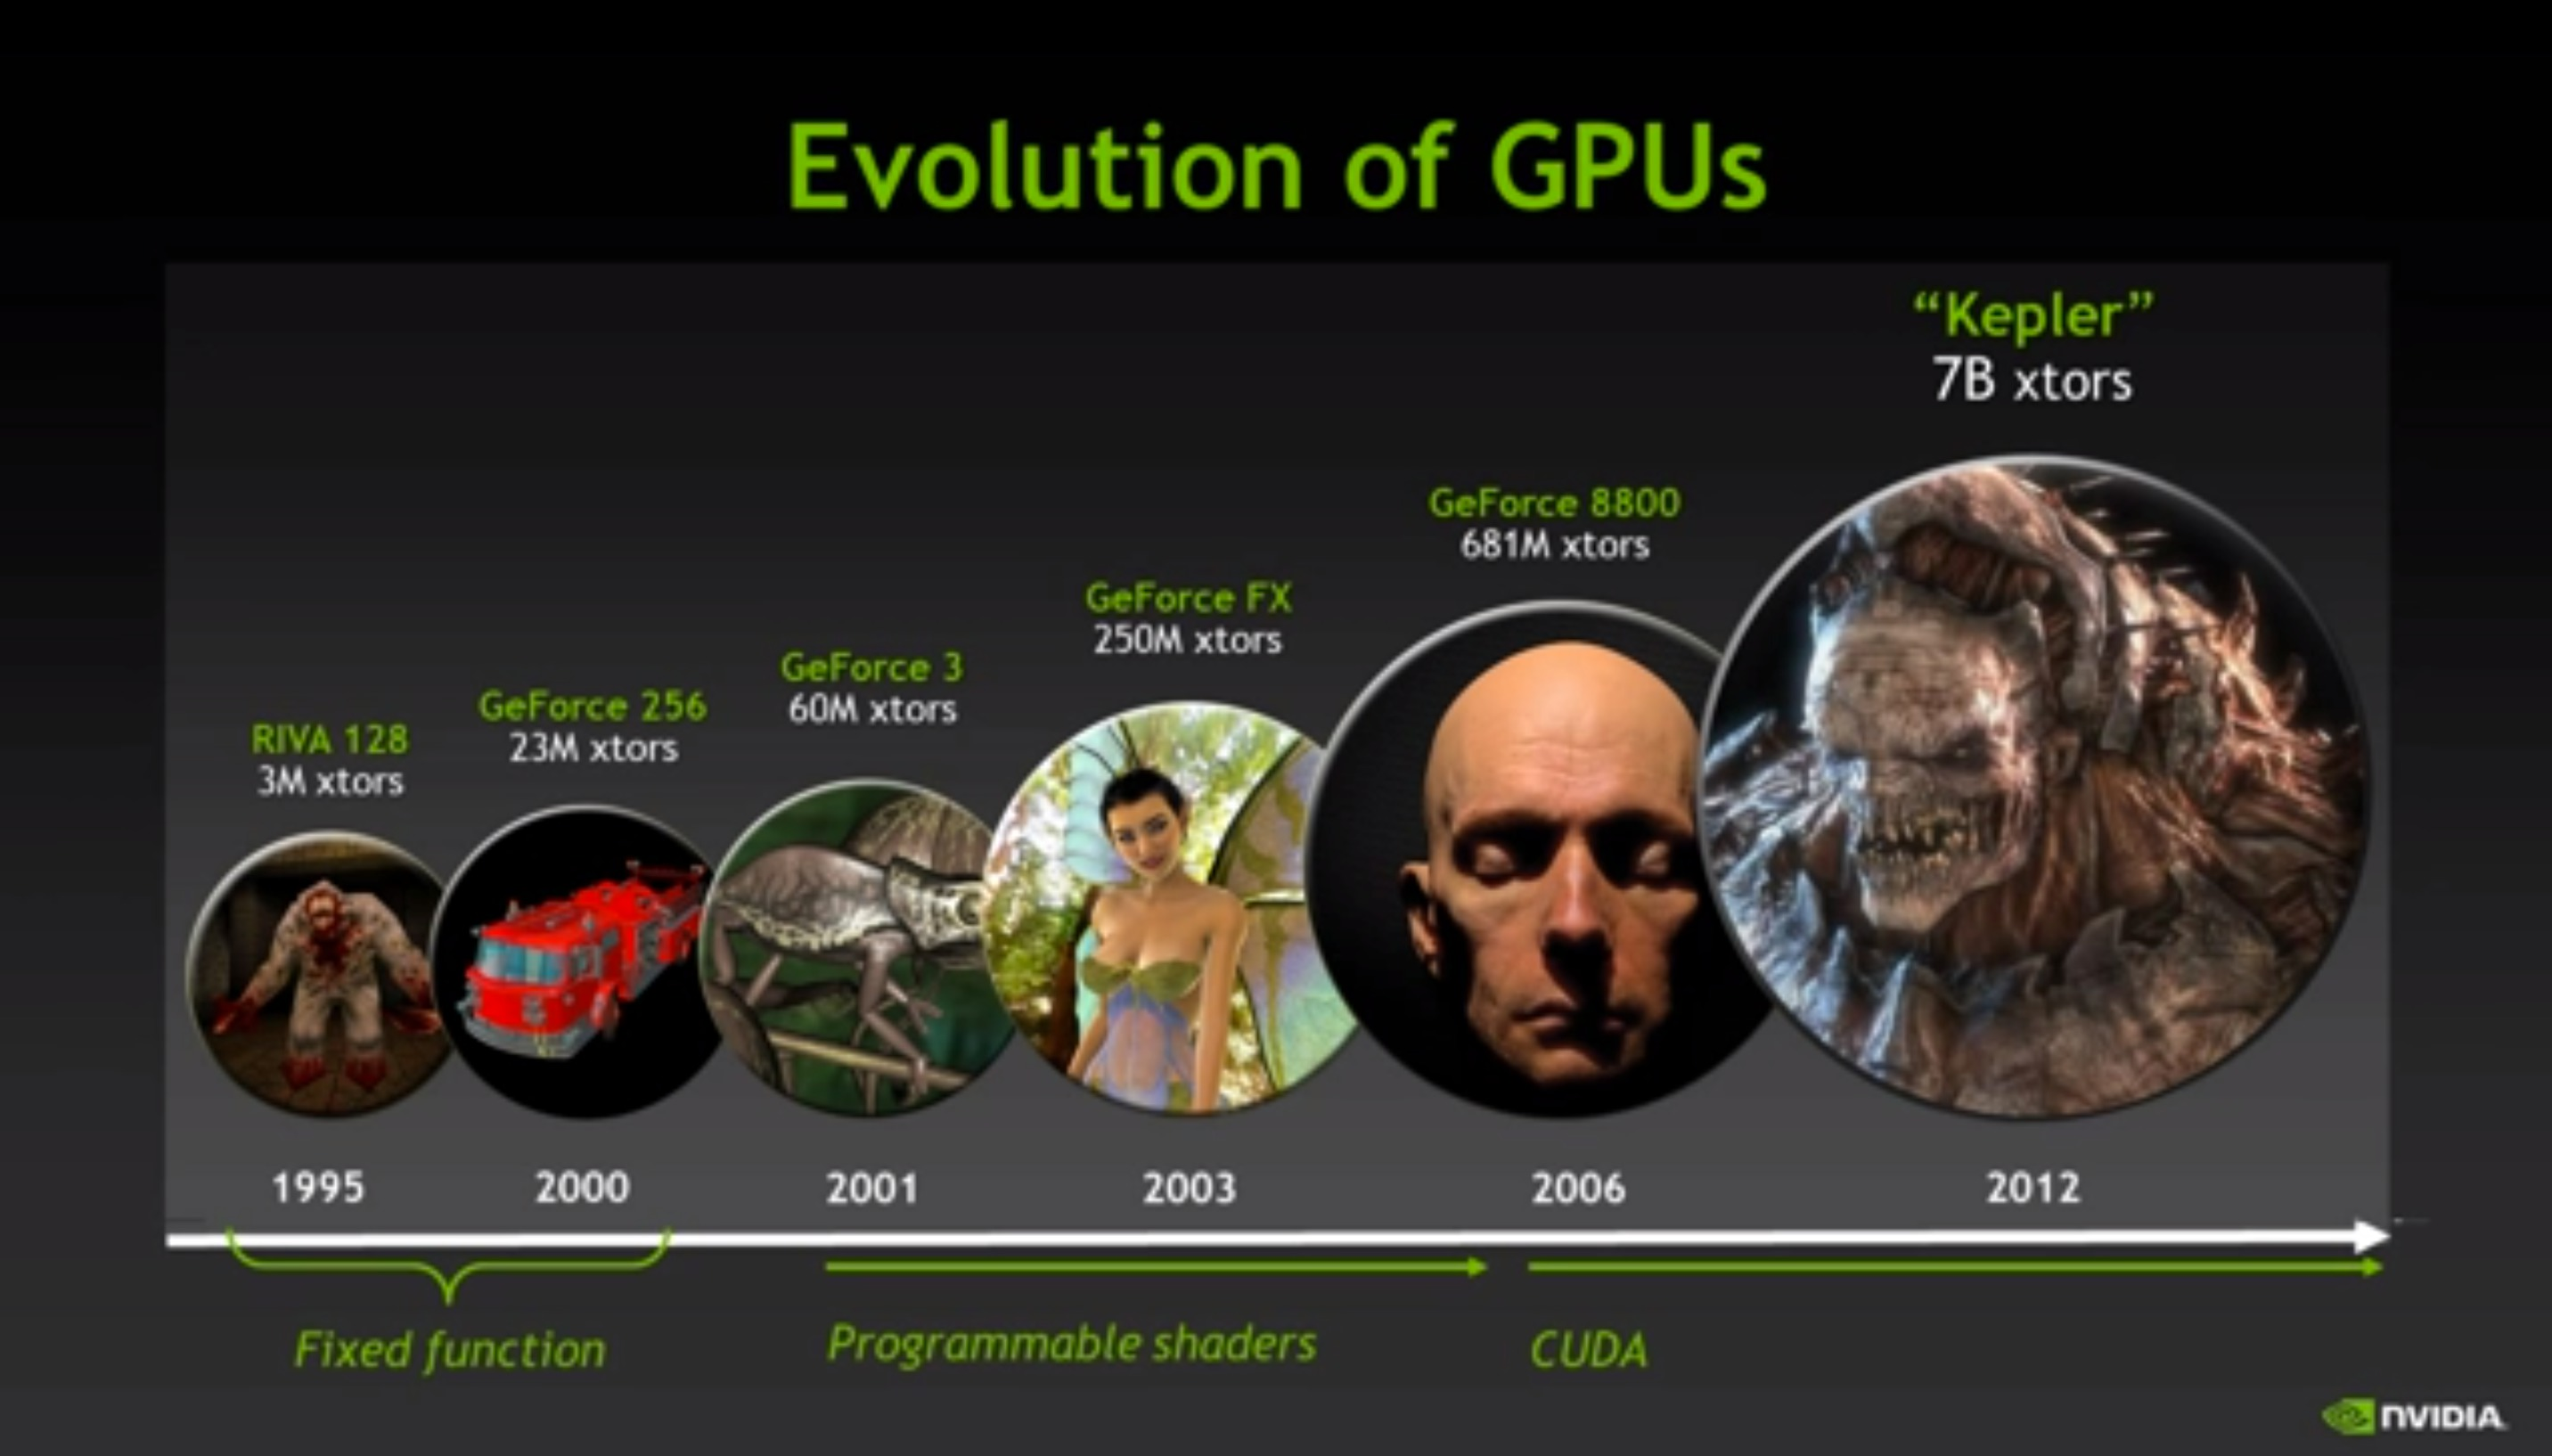

In [16]:
# source http://on-demand.gputechconf.com/gtc/2013/video/S3424-Unlikely-Symbiosis-HPC-And-Gaming.mp4
display(Image("images/ComputerGraphics/GPU-Transistor-Scaling.jpg", width=550))

__Examples of Other Linear Systems Used in Computer Graphics__

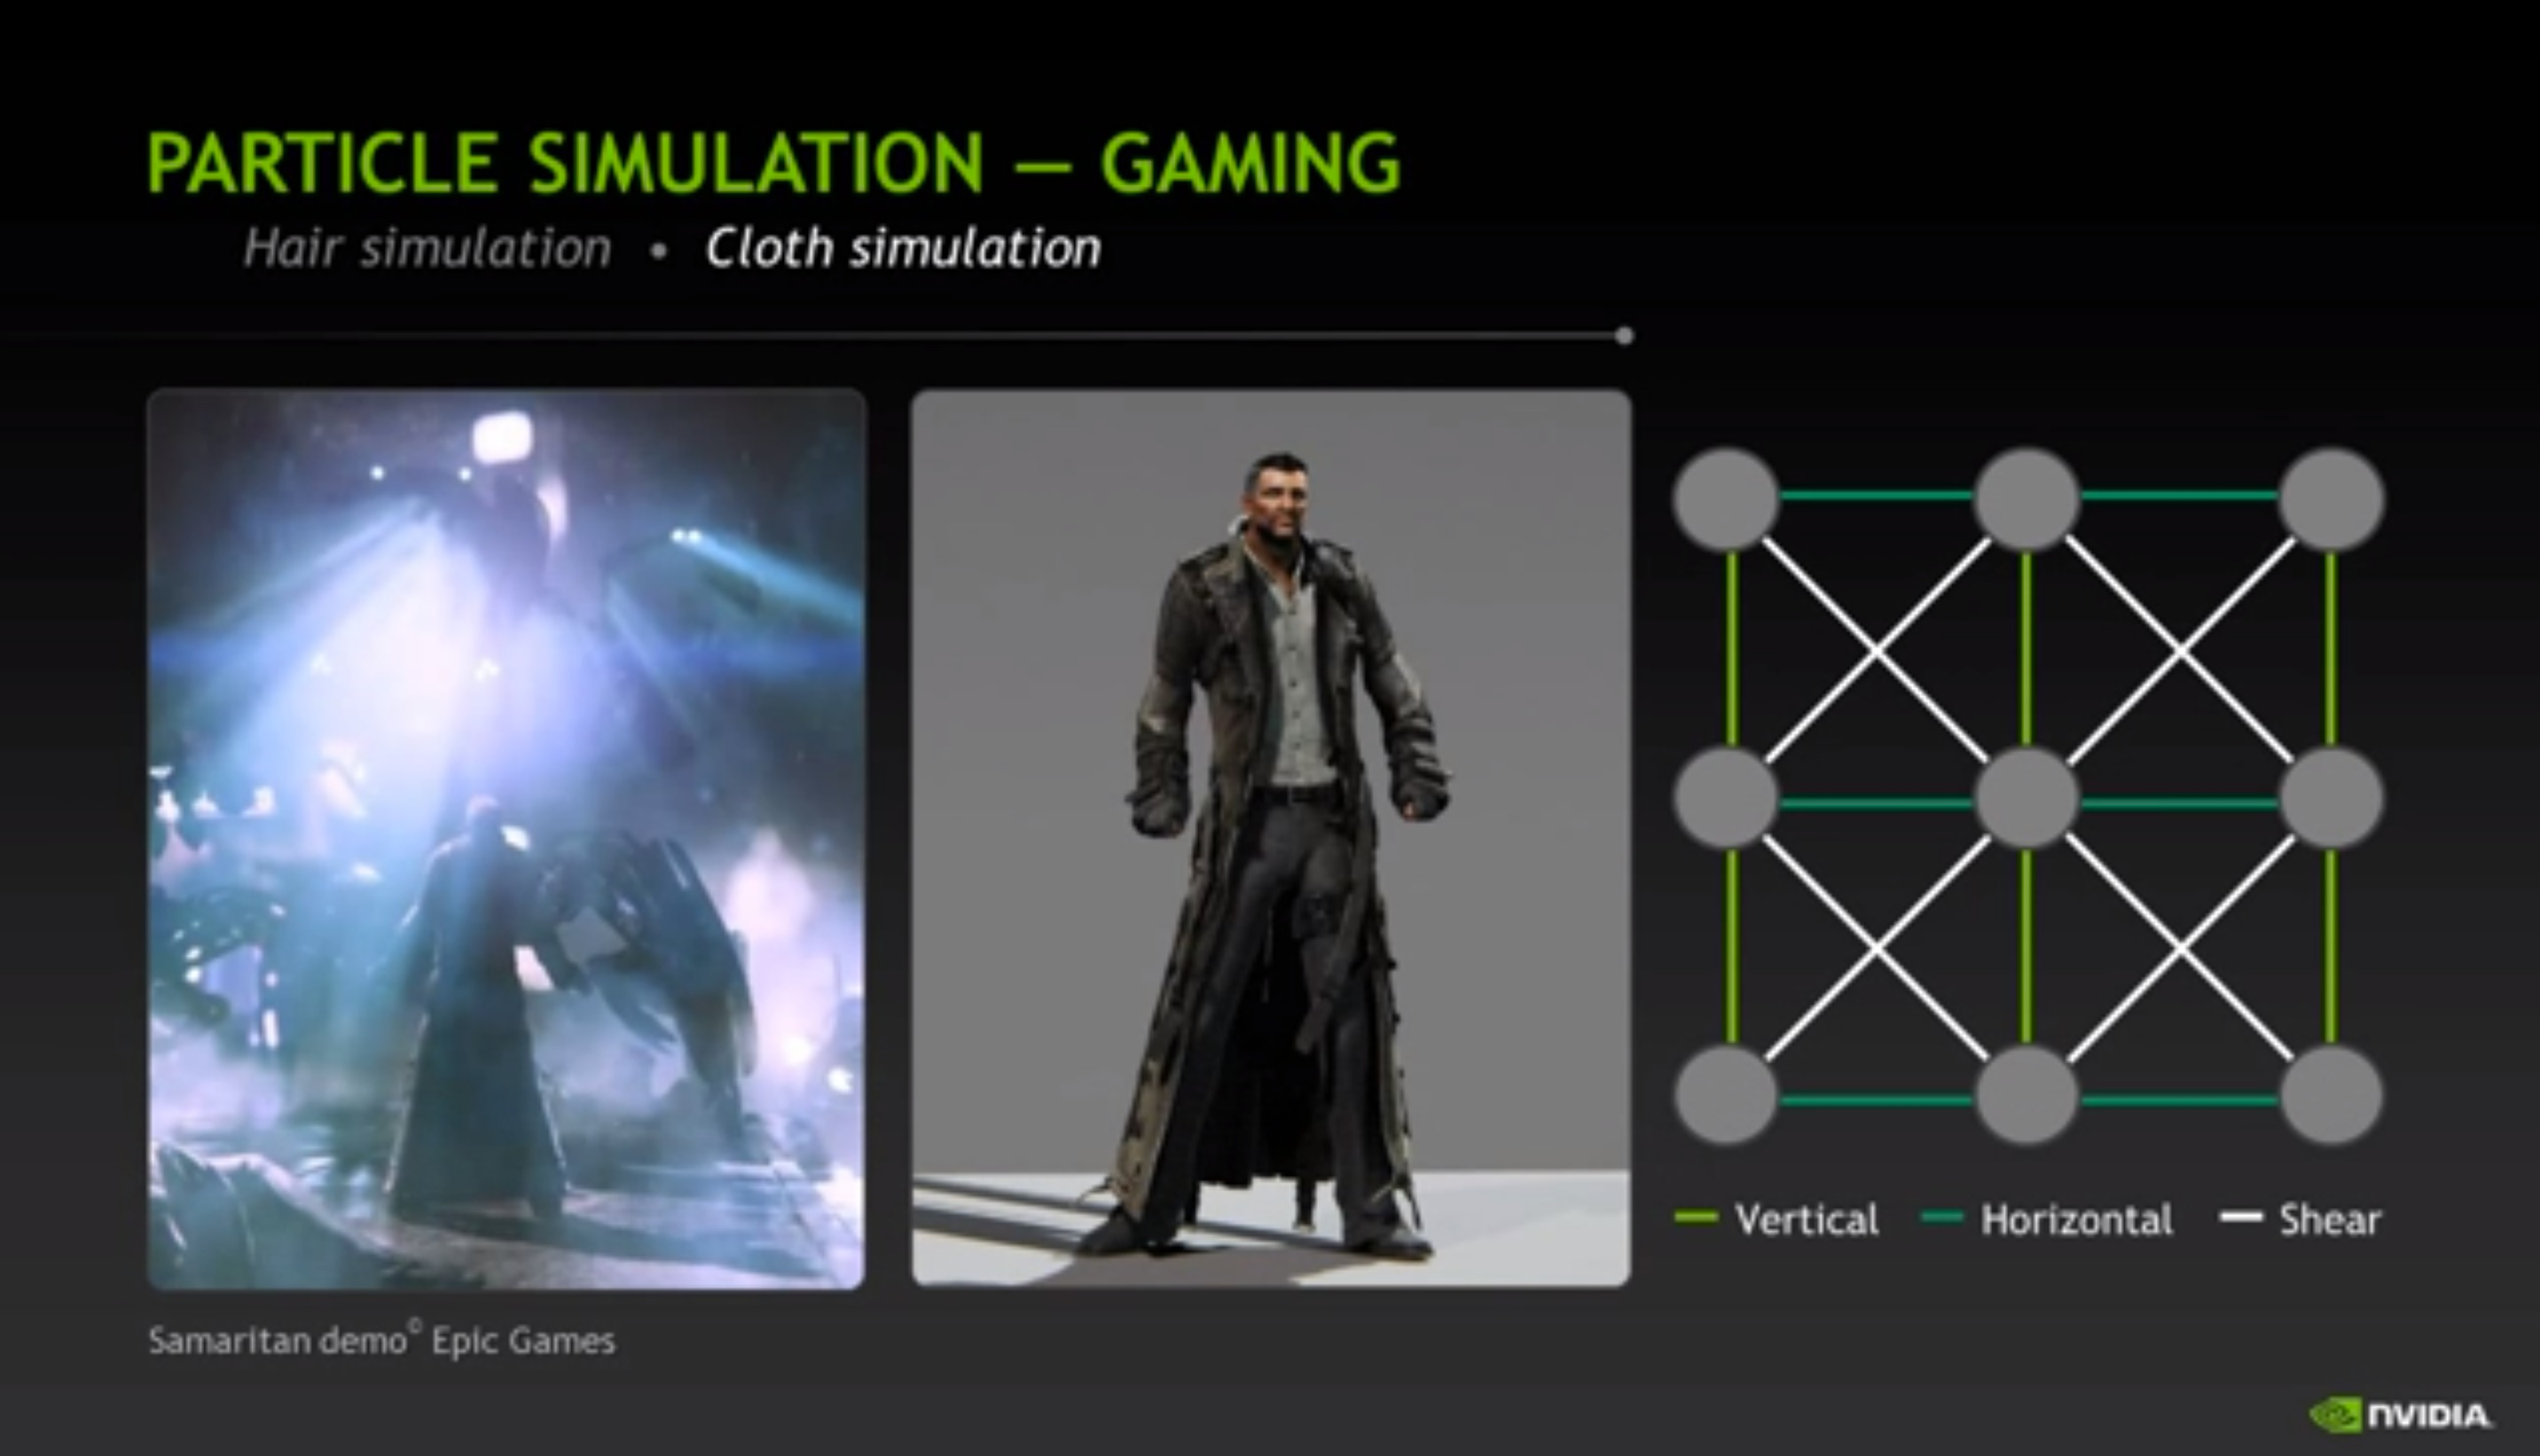

In [17]:
# source http://on-demand.gputechconf.com/gtc/2013/video/S3424-Unlikely-Symbiosis-HPC-And-Gaming.mp4
display(Image("images/ComputerGraphics/Cloth-Simulation.jpg", width=550))

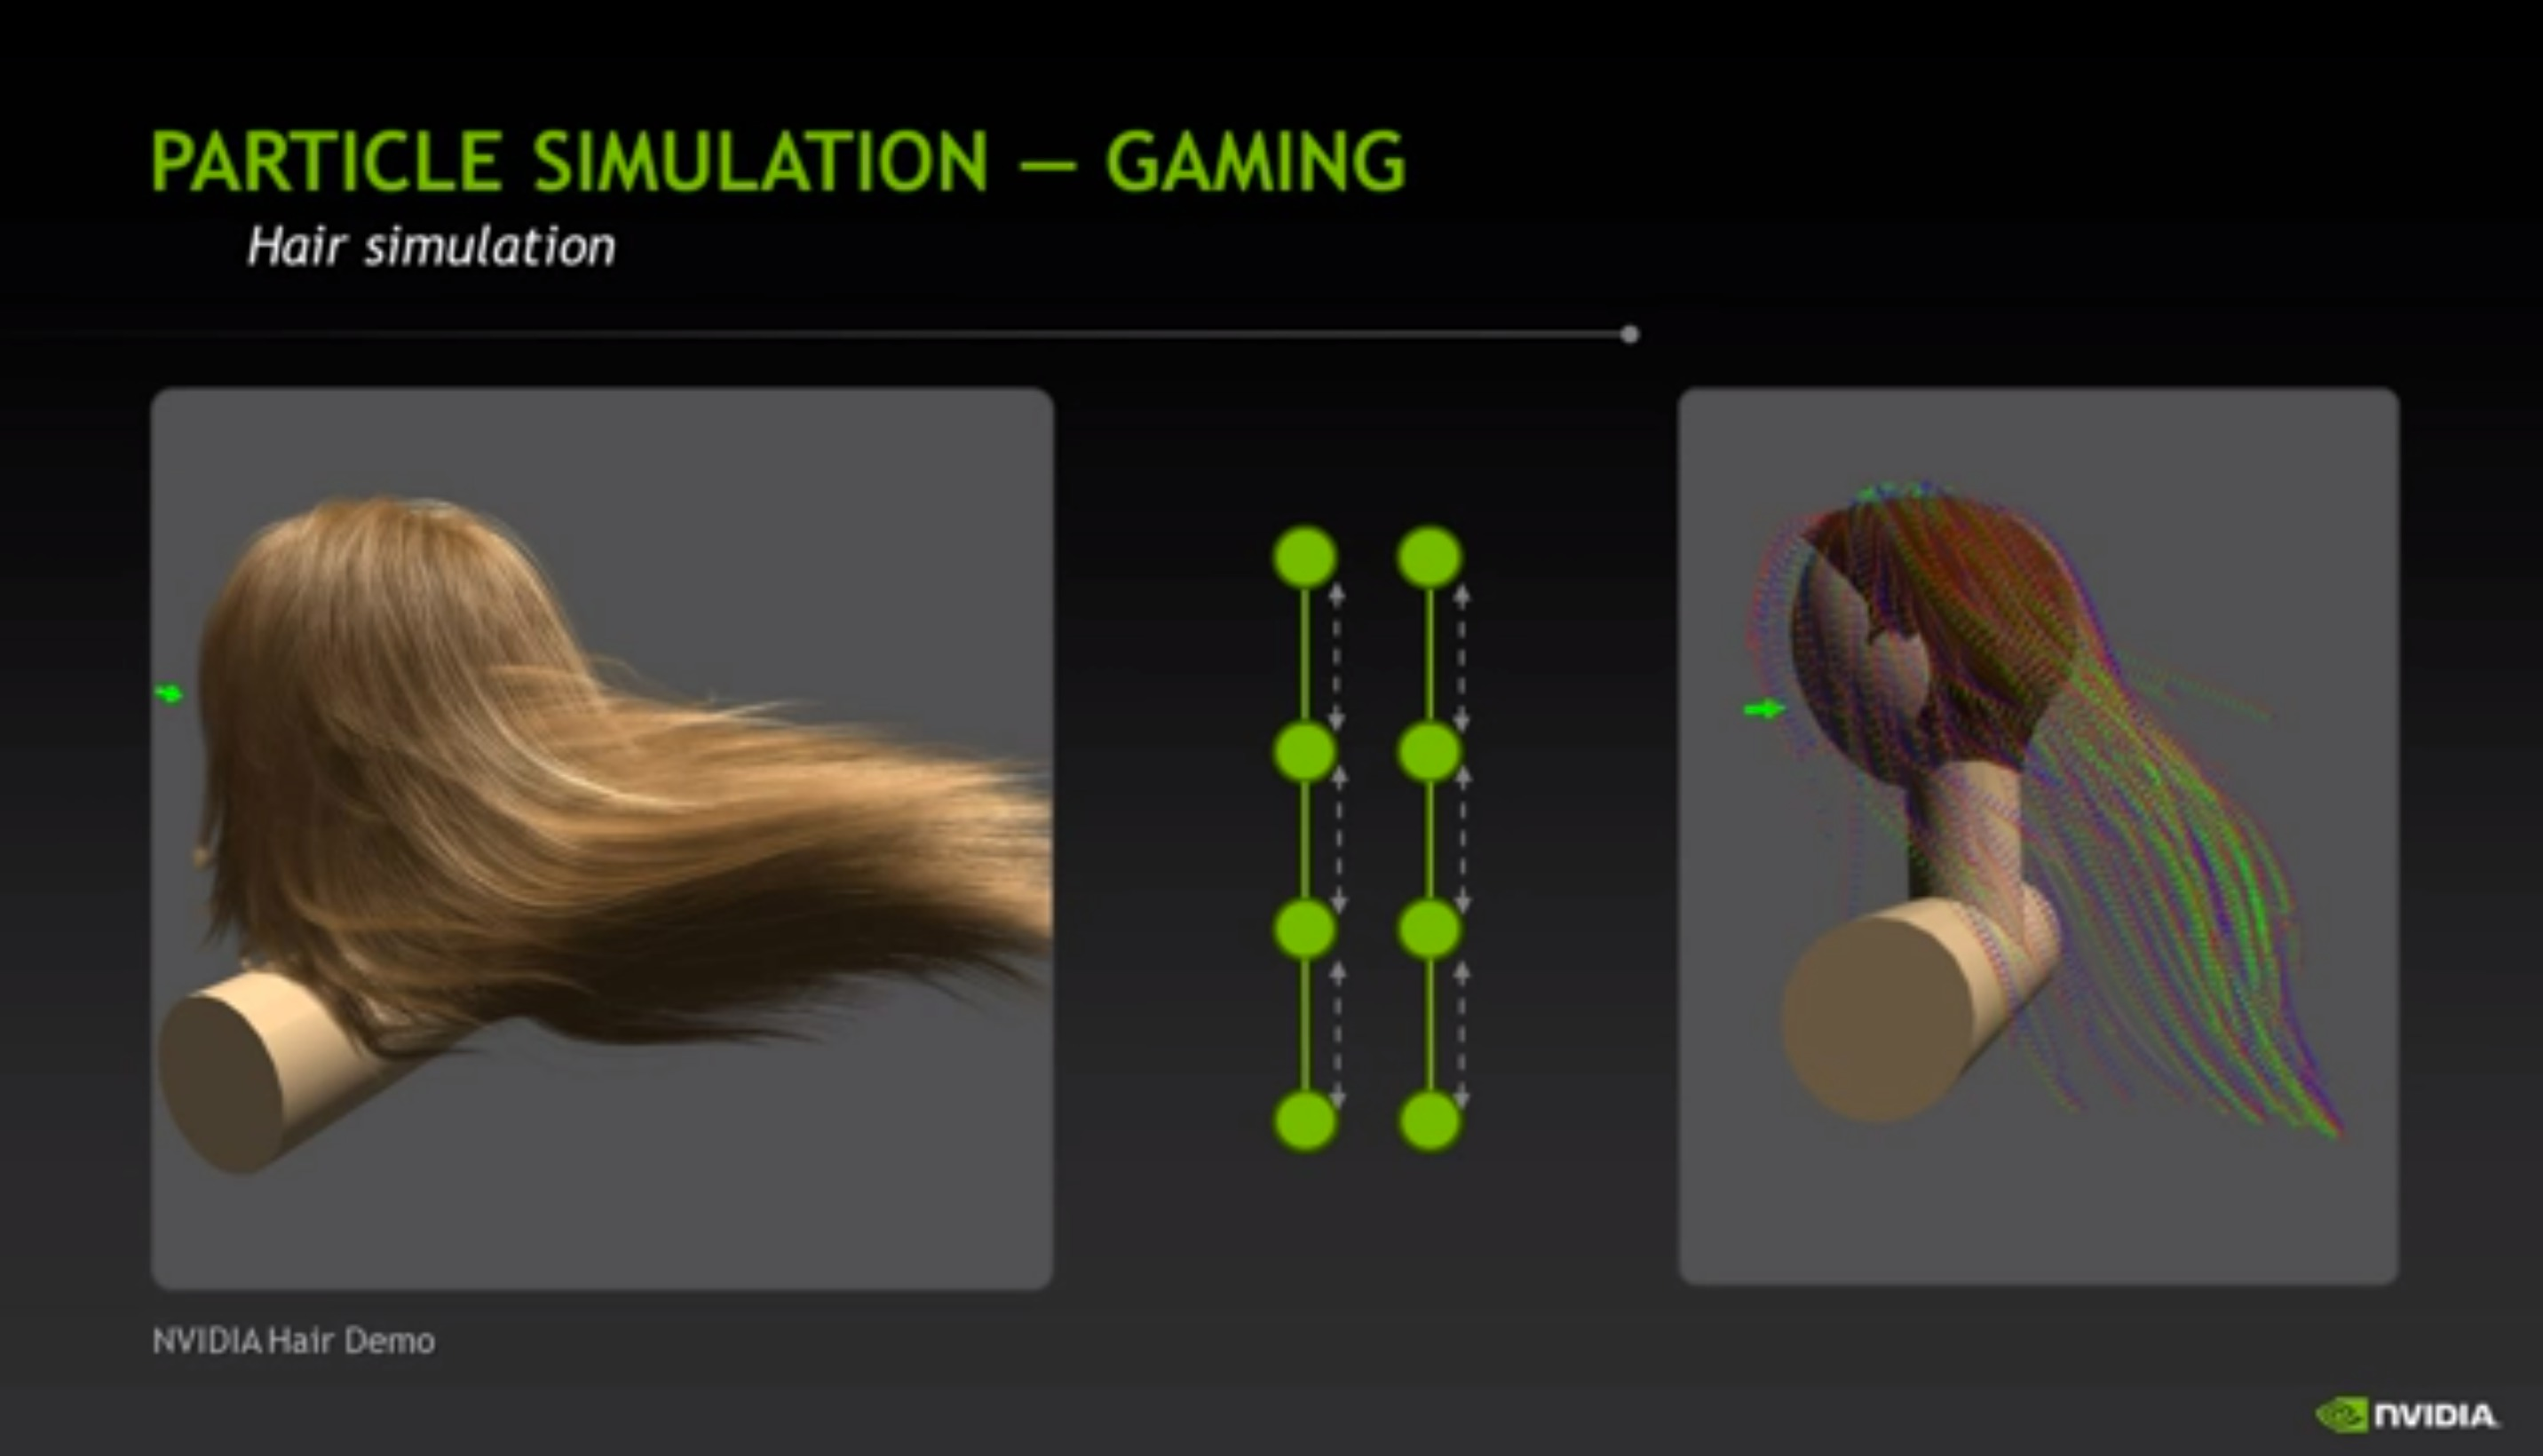

In [18]:
# source http://on-demand.gputechconf.com/gtc/2013/video/S3424-Unlikely-Symbiosis-HPC-And-Gaming.mp4
display(Image("images/ComputerGraphics/Hair-Simulation.jpg", width=550))

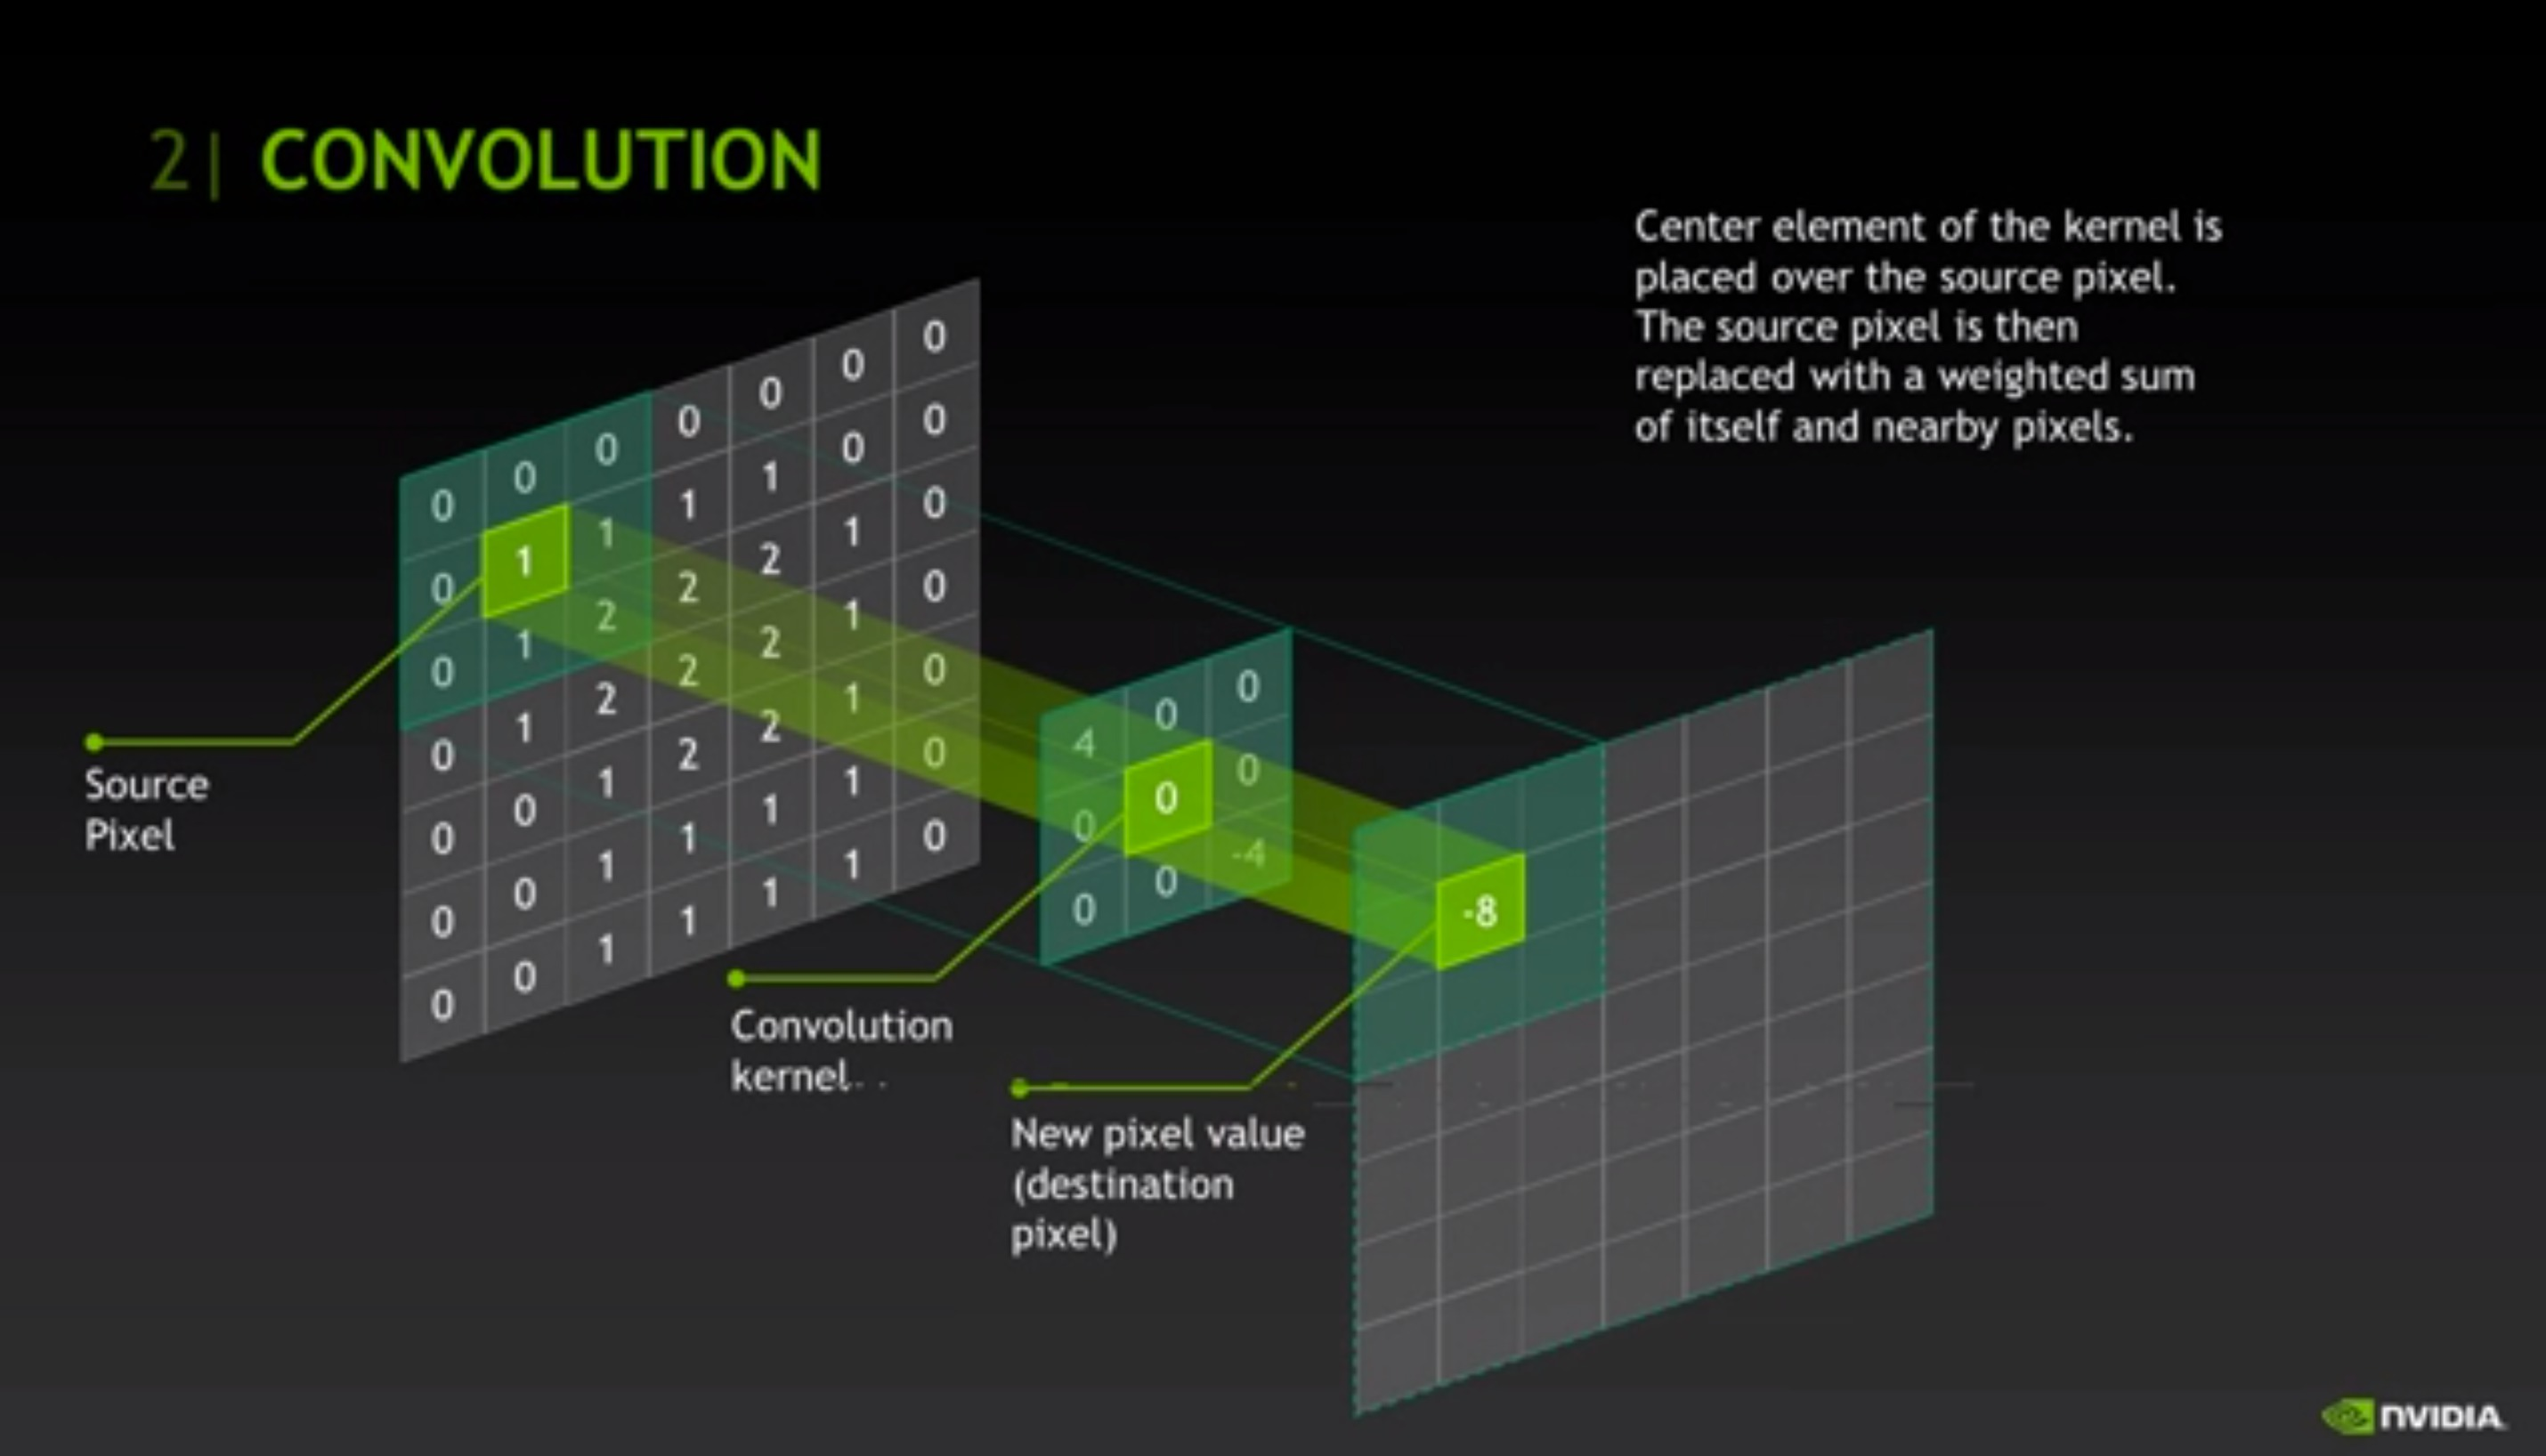

In [19]:
# source http://on-demand.gputechconf.com/gtc/2013/video/S3424-Unlikely-Symbiosis-HPC-And-Gaming.mp4
display(Image("images/ComputerGraphics/Convolution-Diagram.jpg", width=550))

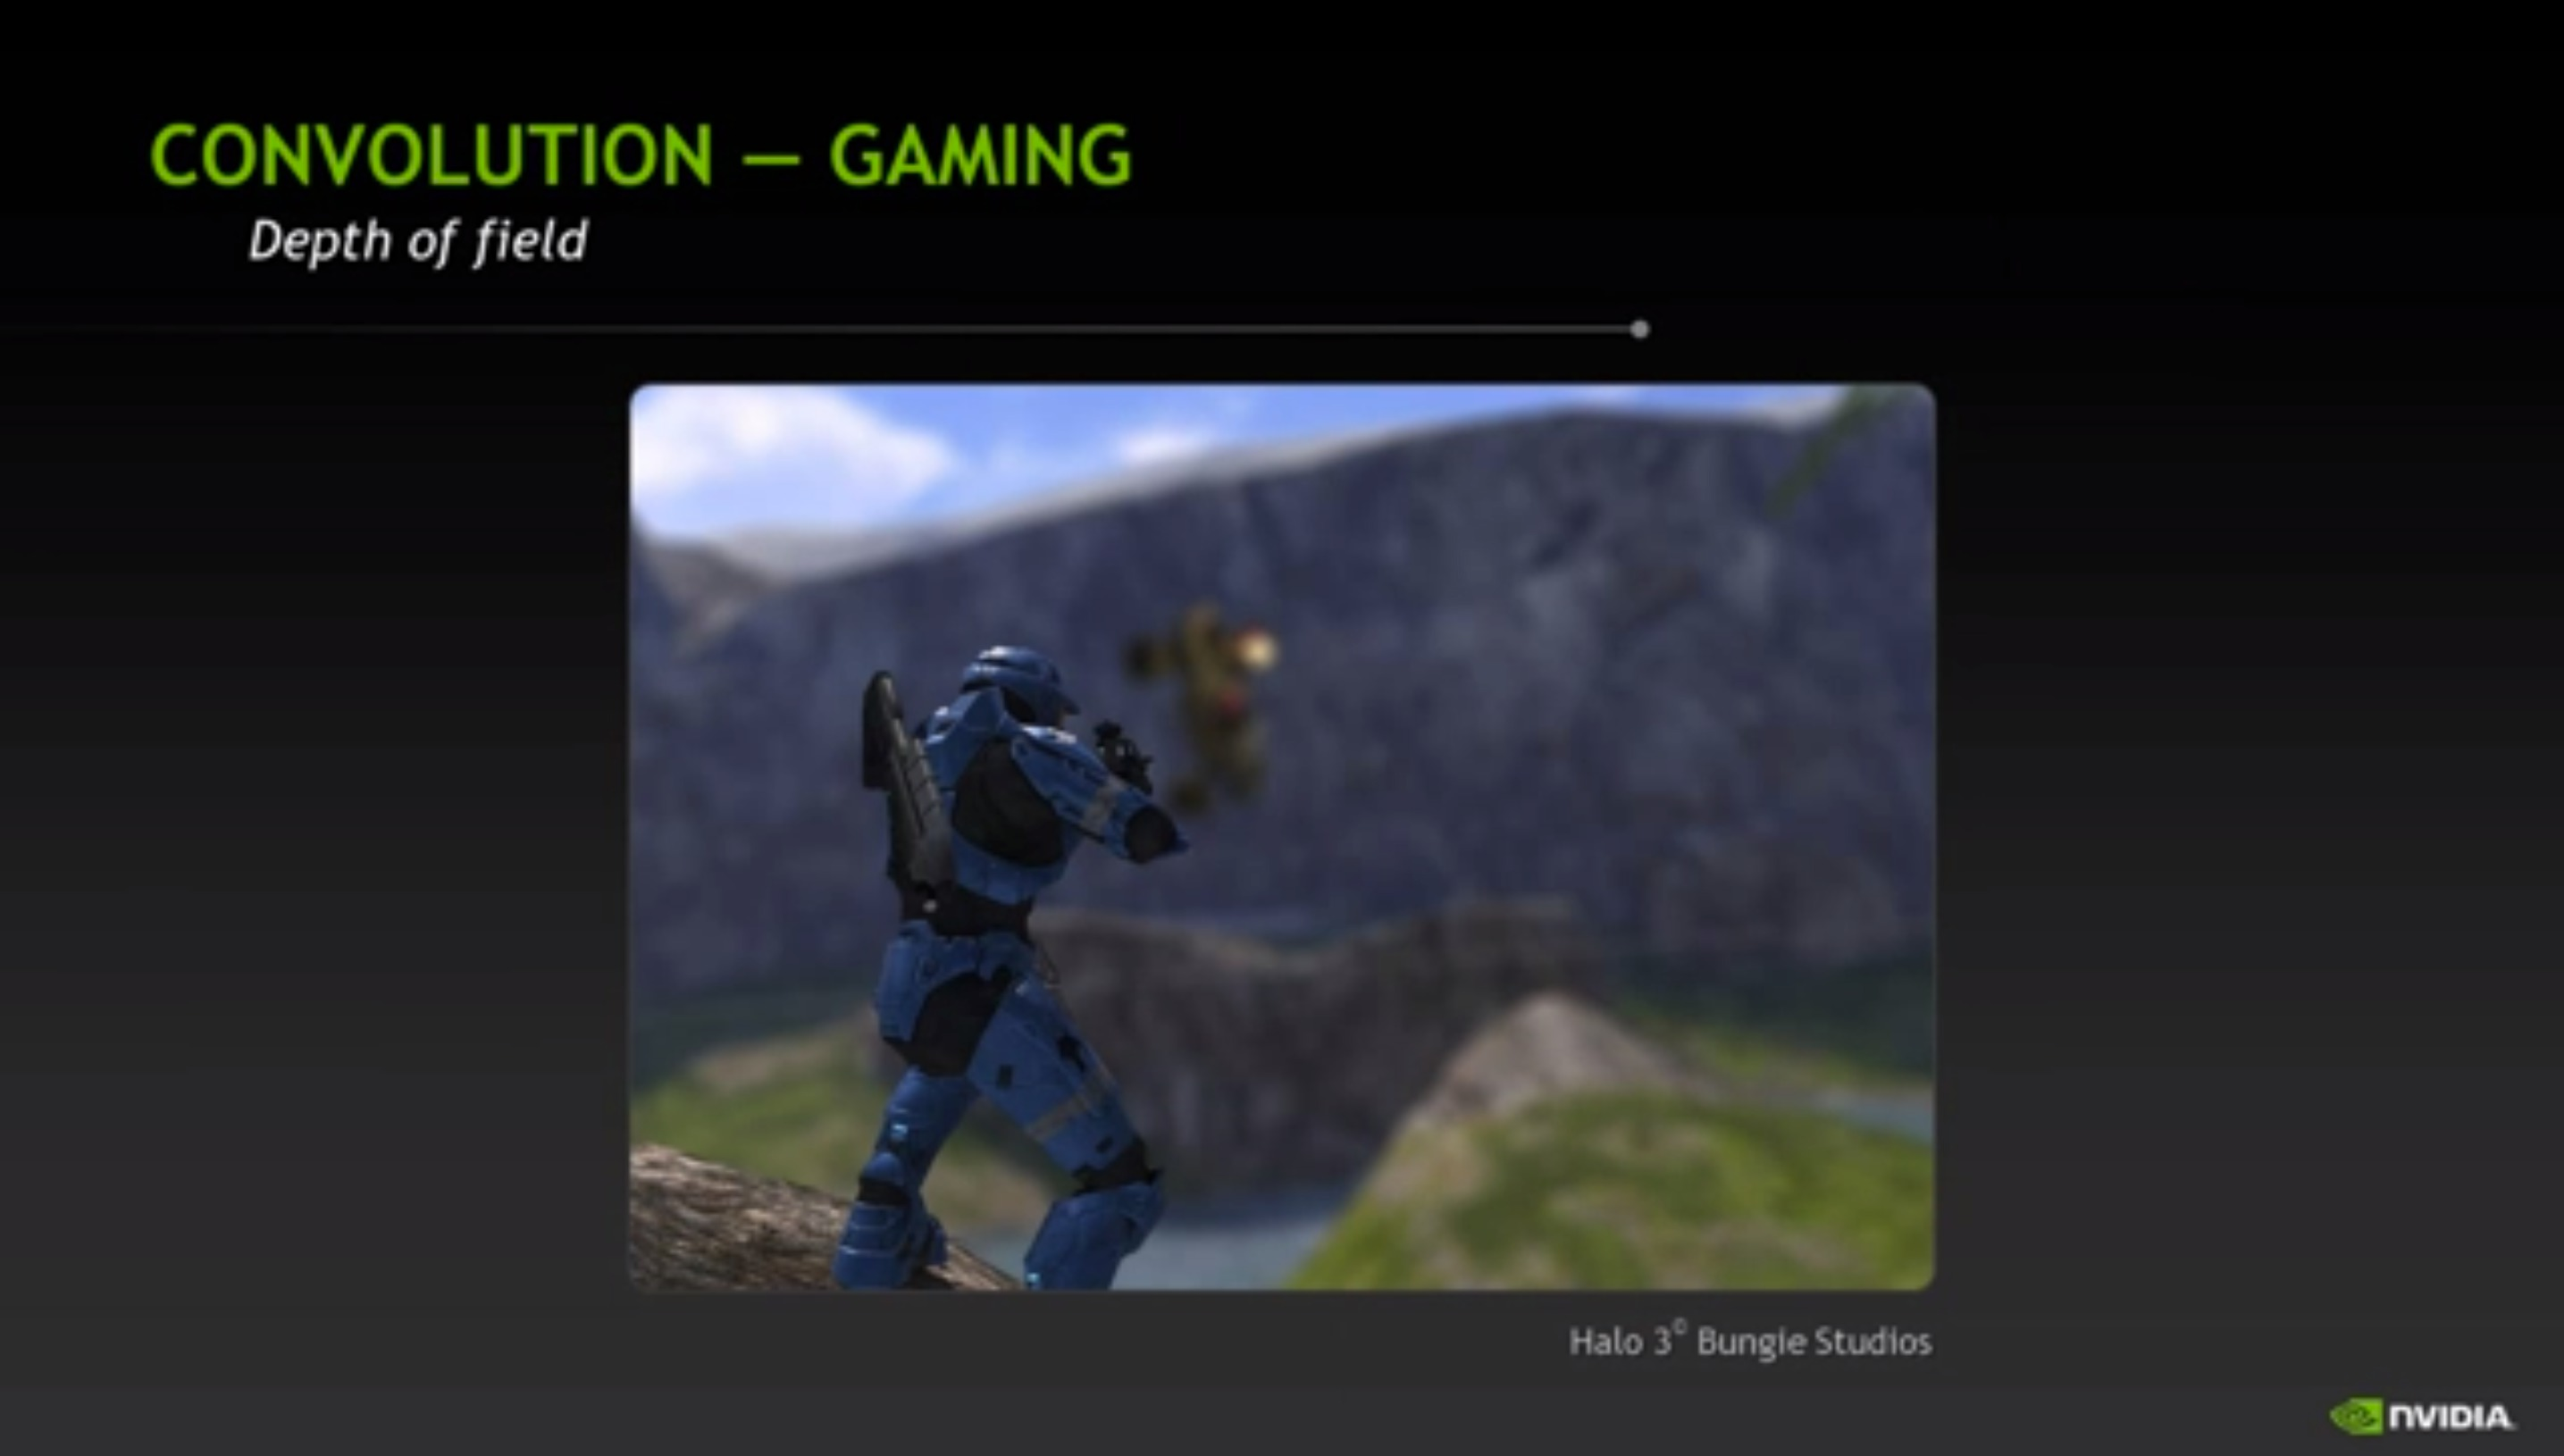

In [20]:
# source http://on-demand.gputechconf.com/gtc/2013/video/S3424-Unlikely-Symbiosis-HPC-And-Gaming.mp4
display(Image("images/ComputerGraphics/Convolution-Image-Example.jpg", width=550))